#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/KT_AI_MiniProject_1_Practice/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [7]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [8]:
# 주어진 데이터 셋을 불러오세요.(3개)
test_data_set = pd.read_csv(path + 'data01_test.csv')
train_data_set = pd.read_csv(path + 'data01_train.csv')
features = pd.read_csv(path + 'features.csv')

In [9]:
#불필요한 칼럼을 삭제하세요.
test_data_set.drop('subject', axis=1, inplace=True)
train_data_set.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [10]:
#전체 데이터의 행,열 개수 확인
train_data_set.shape

(5881, 562)

In [11]:
#전체 데이터의 상위 5개 행 확인

In [12]:
#전체 데이터의 수치형 변수 분포 확인

In [13]:
#전체 데이터의 모든 변수 확인

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [14]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
train_data_set['is_dynamic'] = train_data_set['Activity'].apply(lambda x: 1 if x in dynamic_activities else 0)
test_data_set['is_dynamic'] = test_data_set['Activity'].apply(lambda x: 1 if x in dynamic_activities else 0)

In [15]:
train_data_set

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1


### (2) x, y 분리

In [16]:
#x,y 분리하기
x = train_data_set.drop(columns=['Activity', 'is_dynamic'], axis=1)
y = train_data_set['is_dynamic']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [17]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [18]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [19]:
input_size = x.shape[1]
output_size = 2
print(input_size, output_size)

561 2


In [20]:
# 모델 설계
model1 = Sequential([
    Dense(input_size, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(output_size, activation="softmax")
])

In [21]:
# 컴파일 및 학습
model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [22]:
history1 = model1.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=4,
    verbose=1
)

Epoch 1/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9799 - loss: 0.0522 - val_accuracy: 1.0000 - val_loss: 1.0918e-04
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 5.4143e-05
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 1.0537e-04 - val_accuracy: 0.9980 - val_loss: 0.0541
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 1.9609e-05
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 2.5632e-04 - val_accuracy: 1.0000 - val_loss: 1.7498e-06
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 2.0019e-05 - val_accuracy: 1.0000 - val_loss: 3.6127e-06
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 3.3297e-06 - val_accuracy: 1.0000 - val_loss: 2.4640e-06
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/

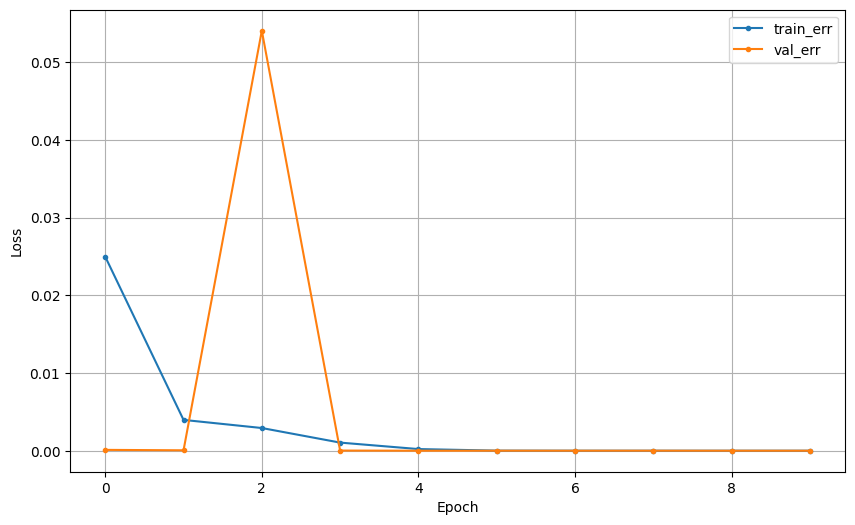

In [23]:
# 학습곡선
dl_history_plot(history1.history)

In [24]:
x_test = test_data_set.drop(columns=['Activity', 'is_dynamic'], axis=1)
y_test = test_data_set['is_dynamic']

x_test = scaler.transform(x_test)

print(x_test.shape, y)

(1471, 561) 0       0
1       0
2       0
3       1
4       1
       ..
5876    0
5877    1
5878    0
5879    1
5880    0
Name: is_dynamic, Length: 5881, dtype: int64


In [25]:
# 예측 및 평가
test_loss_hist = []
test_acc_hist = []
for i in range(5):
  test_loss, test_acc = model1.evaluate(x_test, y_test)
  test_loss_hist.append(test_loss)
  test_acc_hist.append(test_acc)
print("Test Loss:", np.mean(test_loss_hist))
print("Test Accuracy:", np.mean(test_acc_hist))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 8.2429e-05
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.2429e-05
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.2429e-05
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2429e-05
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.2429e-05
Test Loss: 0.00018998159794136882
Test Accuracy: 1.0


#### 2) 모델2

In [60]:
# 모델 설계
model2 = Sequential([
    Dense(32, activation='relu', input_shape=(input_size,)),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
# 컴파일 및 학습
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=10,
                    batch_size=4)

Epoch 1/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9900 - loss: 0.0470 - val_accuracy: 1.0000 - val_loss: 6.7221e-04
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9992 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 6.5821e-04
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 4.1958e-04 - val_accuracy: 1.0000 - val_loss: 2.1715e-04
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 3.1276e-04 - val_accuracy: 1.0000 - val_loss: 1.0886e-04
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 2.7488e-04 - val_accuracy: 1.0000 - val_loss: 9.6794e-05
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 1.9331e-04 - val_accuracy: 0.9980 - val_loss: 0.0029
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 5.5177e-05 - val_accuracy: 1.0000 - val_loss: 2.2451e-05
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3

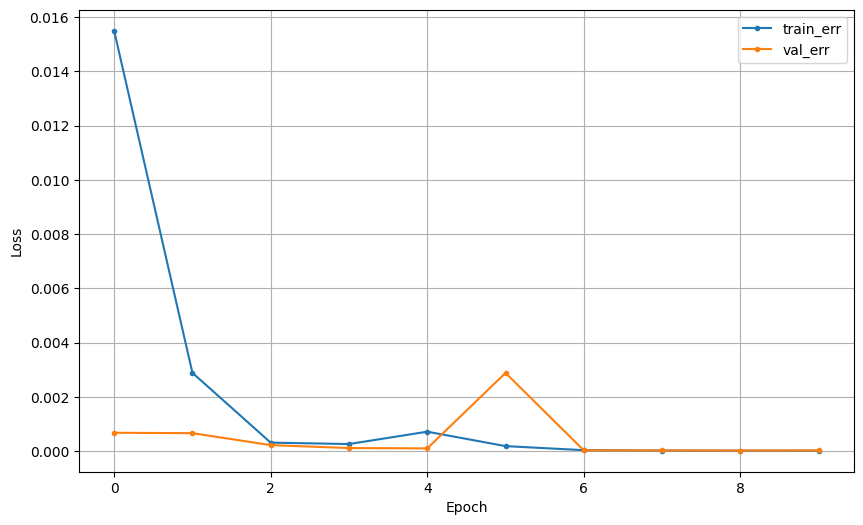

In [62]:
# 학습곡선
dl_history_plot(history2.history)

In [63]:
# 예측 및 평가
loss, acc = model2.evaluate(x_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")

y_pred = model2.predict(x_val)
y_pred_label = (y_pred > 0.5).astype(int)

print(classification_report(y_val, y_pred_label))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5311e-05
Validation Accuracy: 1.0000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       809
           1       1.00      1.00      1.00       662

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [30]:
# (tip) 정적 행동(0)인 데이터 추출
static_data_set = train_data_set[train_data_set['is_dynamic'] == 0]
static_data_set

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,0.257476,-0.413865,0.017374,-0.919666,0.075259,-0.630716,-0.937986,0.176796,-0.613510,-0.866296,...,-0.091605,-0.000793,0.267189,-0.186202,0.098099,0.792970,-0.034020,-0.928148,LAYING,0
5875,0.277378,-0.013298,-0.104322,-0.996596,-0.987491,-0.973345,-0.996372,-0.987746,-0.973512,-0.942156,...,-0.956239,0.122320,0.136275,-0.708377,-0.507788,-0.818263,0.222620,0.035430,STANDING,0
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0


In [31]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑핑
static_x = static_data_set.drop(columns=['Activity', 'is_dynamic'], axis=1)
static_y = static_data_set['Activity']

static_x = scaler.transform(static_x)

label_encoder = LabelEncoder()
static_y = label_encoder.fit_transform(static_y)
static_classes = label_encoder.classes_

In [32]:
s_x_train, s_x_val, s_y_train, s_y_val = train_test_split(static_x, static_y, test_size=0.25, random_state=42)

In [33]:
# 모델 설계
static_model = Sequential([
    Dense(s_x_train.shape[1], activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

In [34]:
# 컴파일 및 학습
static_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [35]:
history_static = static_model.fit(
    s_x_train, s_y_train,
    validation_data=(s_x_val, s_y_val),
    epochs=10,
    batch_size=4,
    verbose=1
)

Epoch 1/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5417 - loss: 0.8307 - val_accuracy: 0.8121 - val_loss: 0.3846
Epoch 2/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8559 - loss: 0.3609 - val_accuracy: 0.9023 - val_loss: 0.2173
Epoch 3/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9120 - loss: 0.2284 - val_accuracy: 0.9419 - val_loss: 0.1334
Epoch 4/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9050 - loss: 0.2232 - val_accuracy: 0.7862 - val_loss: 0.7195
Epoch 5/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9302 - loss: 0.1873 - val_accuracy: 0.9555 - val_loss: 0.1046
Epoch 6/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9497 - loss: 0.1356 - val_accuracy: 0.9617 - val_loss: 0.0956
Epoch 7/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9500 - loss: 0.1321 - val_accuracy: 0.9370 - val_loss: 0.1584
Epoch 8/10
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9513 - loss: 0.1200 - val_accuracy: 0.

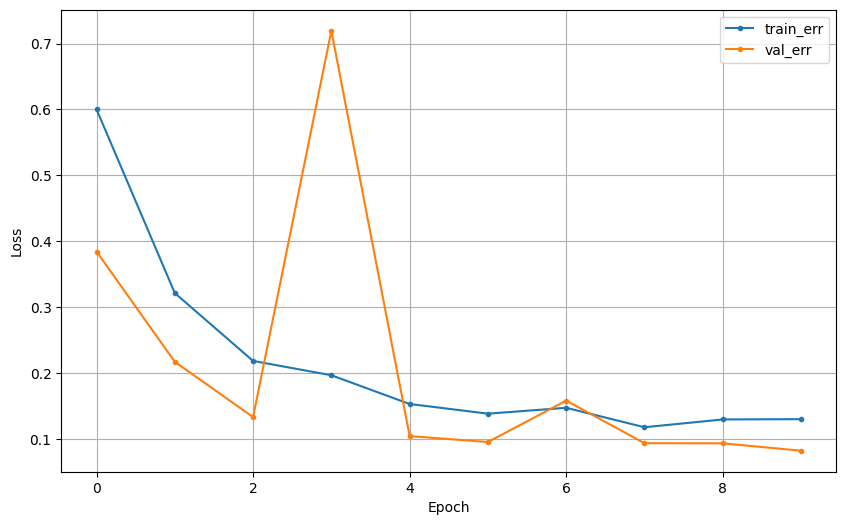

In [36]:
# 학습곡선
dl_history_plot(history_static.history)

In [37]:
static_x_test = test_data_set[test_data_set['is_dynamic'] == 0].drop(columns=['Activity', 'is_dynamic'], axis=1)
static_y_test = test_data_set[test_data_set['is_dynamic'] == 0]['Activity']

static_x_test = scaler.transform(static_x_test)
static_y_test = label_encoder.transform(static_y_test)

In [38]:
# 예측 및 평가
test_loss_hist = []
test_acc_hist = []
for i in range(5):
  test_loss, test_acc = static_model.evaluate(static_x_test, static_y_test)
  test_loss_hist.append(test_loss)
  test_acc_hist.append(test_acc)
print("Test Loss:", np.mean(test_loss_hist))
print("Test Accuracy:", np.mean(test_acc_hist))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.1937
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.1937
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.1937
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.1937
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.1937
Test Loss: 0.19555960595607758
Test Accuracy: 0.918367326259613


#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [39]:
# (tip) 동적 행동(1)인 데이터 추출
dynamic_data_set = train_data_set[train_data_set['is_dynamic'] == 1]
dynamic_data_set

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,WALKING,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5868,0.277709,-0.053919,-0.098746,-0.589970,-0.076626,-0.500837,-0.605474,-0.142798,-0.506696,-0.533485,...,-0.268237,-0.076922,0.706620,-0.954969,-0.324779,-0.691663,0.153974,-0.196833,WALKING,1
5869,0.252496,-0.009773,-0.118293,-0.155168,-0.244513,-0.044524,-0.244367,-0.229509,-0.042199,0.291682,...,-0.752980,0.619246,-0.684483,0.924623,-0.353041,-0.775518,0.253218,0.013216,WALKING_UPSTAIRS,1
5873,0.264961,-0.034719,-0.088140,-0.368158,-0.074514,-0.229606,-0.394387,-0.082437,-0.243525,-0.261087,...,-0.046157,0.037517,-0.903692,0.614933,-0.610918,-0.601604,0.335996,0.156518,WALKING,1
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1


In [40]:
# (tip) map 활용해서 숫자레이블로 매핑핑
dynamic_x = dynamic_data_set.drop(columns=['Activity', 'is_dynamic'], axis=1)
dynamic_y = dynamic_data_set['Activity']

dynamic_x = scaler.transform(dynamic_x)
dynamic_y = label_encoder.fit_transform(dynamic_y)

dynamic_classes = label_encoder.classes_

In [41]:
d_train_x, d_val_x, d_train_y, d_val_y = train_test_split(dynamic_x, dynamic_y, test_size=0.25, random_state=42)

In [42]:
# 모델 설계
dynamic_model = Sequential([
    Dense(dynamic_x.shape[1], activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

In [43]:
# 컴파일 및 학습
dynamic_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [44]:
dynamic_history = dynamic_model.fit(
    d_train_x, d_train_y,
    epochs=10,
    batch_size=4,
    verbose=1,
    validation_data=(d_val_x, d_val_y)
)

Epoch 1/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6552 - loss: 0.7388 - val_accuracy: 0.9426 - val_loss: 0.1905
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9485 - loss: 0.1613 - val_accuracy: 0.9441 - val_loss: 0.1432
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9501 - loss: 0.1498 - val_accuracy: 0.9154 - val_loss: 0.2117
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9471 - loss: 0.1379 - val_accuracy: 0.9743 - val_loss: 0.0782
Epoch 5/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9679 - loss: 0.0960 - val_accuracy: 0.9773 - val_loss: 0.0611
Epoch 6/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9845 - loss: 0.0524 - val_accuracy: 0.9426 - val_loss: 0.1442
Epoch 7/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9611 - loss: 0.1142 - val_accuracy: 0.9713 - val_loss: 0.0898
Epoch 8/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9581 - loss: 0.1092 - val_accuracy: 0.

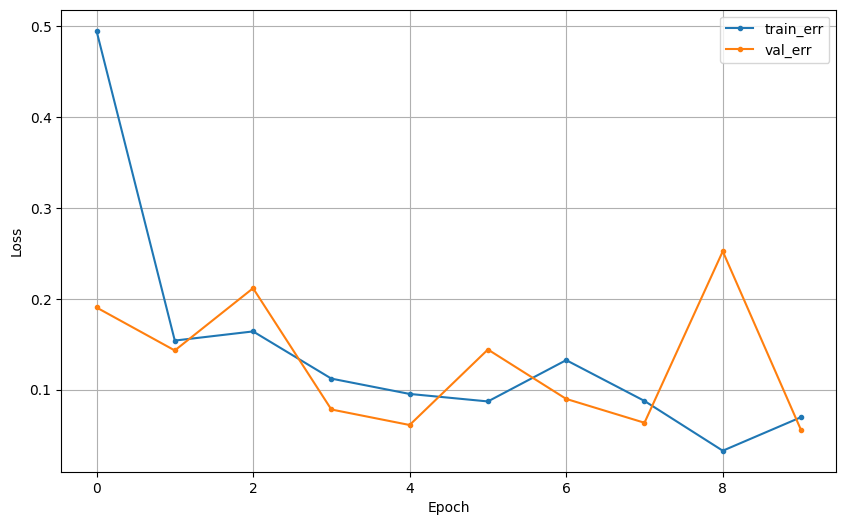

In [45]:
# 학습곡선
dl_history_plot(dynamic_history.history)

In [46]:
# 예측 및 평가
loss_hist = []
acc_hist = []
for i in range(5):
  test_loss, test_acc = dynamic_model.evaluate(dynamic_x, dynamic_y)
  loss_hist.append(test_loss)
  acc_hist.append(test_acc)
print("Test Loss:", np.mean(loss_hist))
print("Test Accuracy:", np.mean(acc_hist))

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9893 - loss: 0.0296
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0296
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0296
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0296
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0296
Test Loss: 0.03225238621234894
Test Accuracy: 0.9882886409759521


### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [47]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

In [48]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기
def pipeline(data):
  data = scaler.transform(data)
  is_dynamic_data = model1.predict(data).argmax()
  print(is_dynamic_data)
  if is_dynamic_data == 0:
    # print("정적 동작입니다.")
    result = static_model.predict(data)
    # print("예측 결과 : ", static_classes[result.argmax()])
    return static_classes[result.argmax()]

  else:
    # print("동적 동작 입니다.")
    result = dynamic_model.predict(data)
    # print("예측 결과 : ", dynamic_classes[result.argmax()])
    return dynamic_classes[result.argmax()]



#### 2) test 셋으로 예측하고 평가하기

In [49]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기

In [50]:
sample_data = test_data_set.sample(n=1)
print("정답 : ", sample_data['Activity'])
pipeline(sample_data.drop(columns=['Activity', 'is_dynamic'], axis=1))

정답 :  352    SITTING
Name: Activity, dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


'SITTING'

In [56]:
from tqdm import tqdm

# 테스트셋 준비
test_sample_data = test_data_set
test_x = test_sample_data.drop(columns=['Activity', 'is_dynamic'], axis=1)
test_y = test_sample_data['Activity']

# 스케일링은 pipeline 내부에서 처리되므로 생략

# 예측
y_pred = []
y_true = []

for row, label in tqdm(zip(test_x.to_numpy(), test_y), total=len(test_y), desc="Evaluating"):
    pred = pipeline(row.reshape(1, -1))  # 1개 샘플 예측
    y_pred.append(pred)                 # 문자열 클래스
    y_true.append(label)               # 문자열 클래스

# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)
print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")

Evaluating:   0%|          | 0/1471 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:   0%|          | 1/1471 [00:00<06:17,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:   0%|          | 2/1471 [00:00<06:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:   0%|          | 3/1471 [00:00<07:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   0%|          | 4/1471 [00:01<07:29,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   0%|          | 5/1471 [00:01<06:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   0%|          | 6/1471 [00:01<05:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:   0%|          | 7/1471 [00:01<04:40,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   1%|          | 8/1471 [00:01<04:32,  5.37it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   1%|          | 9/1471 [00:01<04:08,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:   1%|          | 10/1471 [00:02<03:55,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   1%|          | 11/1471 [00:02<03:43,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   1%|          | 12/1471 [00:02<04:00,  6.07it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   1%|          | 13/1471 [00:02<03:52,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   1%|          | 14/1471 [00:02<04:02,  6.00it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   1%|          | 15/1471 [00:02<03:51,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   1%|          | 16/1471 [00:03<03:42,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   1%|          | 17/1471 [00:03<03:52,  6.25it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   1%|          | 18/1471 [00:03<04:07,  5.88it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   1%|▏         | 19/1471 [00:03<04:11,  5.77it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   1%|▏         | 20/1471 [00:03<04:00,  6.04it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   1%|▏         | 21/1471 [00:03<03:47,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   1%|▏         | 22/1471 [00:03<03:33,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   2%|▏         | 23/1471 [00:04<03:46,  6.39it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   2%|▏         | 24/1471 [00:04<03:43,  6.47it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   2%|▏         | 25/1471 [00:04<03:56,  6.12it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   2%|▏         | 26/1471 [00:04<04:03,  5.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   2%|▏         | 27/1471 [00:04<03:54,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   2%|▏         | 28/1471 [00:04<04:00,  6.00it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   2%|▏         | 29/1471 [00:05<03:49,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   2%|▏         | 30/1471 [00:05<03:44,  6.43it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   2%|▏         | 31/1471 [00:05<03:57,  6.07it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   2%|▏         | 32/1471 [00:05<03:45,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:   2%|▏         | 33/1471 [00:05<03:42,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   2%|▏         | 34/1471 [00:05<03:32,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   2%|▏         | 35/1471 [00:06<03:27,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:   2%|▏         | 36/1471 [00:06<03:52,  6.18it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   3%|▎         | 37/1471 [00:06<03:43,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   3%|▎         | 38/1471 [00:06<03:55,  6.08it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   3%|▎         | 39/1471 [00:06<03:46,  6.32it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   3%|▎         | 40/1471 [00:06<04:01,  5.92it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   3%|▎         | 41/1471 [00:07<03:49,  6.23it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   3%|▎         | 42/1471 [00:07<04:03,  5.88it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   3%|▎         | 43/1471 [00:07<04:10,  5.70it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   3%|▎         | 44/1471 [00:07<04:14,  5.61it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   3%|▎         | 45/1471 [00:07<03:57,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   3%|▎         | 46/1471 [00:07<03:50,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   3%|▎         | 47/1471 [00:08<03:39,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   3%|▎         | 48/1471 [00:08<03:55,  6.03it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   3%|▎         | 49/1471 [00:08<04:03,  5.84it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   3%|▎         | 50/1471 [00:08<04:07,  5.73it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   3%|▎         | 51/1471 [00:08<03:54,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   4%|▎         | 52/1471 [00:08<03:59,  5.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   4%|▎         | 53/1471 [00:09<04:01,  5.87it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   4%|▎         | 54/1471 [00:09<03:54,  6.05it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   4%|▎         | 55/1471 [00:09<04:19,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   4%|▍         | 56/1471 [00:09<04:07,  5.72it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   4%|▍         | 57/1471 [00:09<04:09,  5.67it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   4%|▍         | 58/1471 [00:09<03:59,  5.89it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   4%|▍         | 59/1471 [00:10<03:48,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   4%|▍         | 60/1471 [00:10<04:17,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   4%|▍         | 61/1471 [00:10<04:01,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:   4%|▍         | 62/1471 [00:10<04:35,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:   4%|▍         | 63/1471 [00:11<05:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   4%|▍         | 64/1471 [00:11<05:05,  4.61it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:   4%|▍         | 65/1471 [00:11<05:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:   4%|▍         | 66/1471 [00:11<05:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:   5%|▍         | 67/1471 [00:11<05:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:   5%|▍         | 68/1471 [00:12<05:28,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:   5%|▍         | 69/1471 [00:12<05:29,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:   5%|▍         | 70/1471 [00:12<05:40,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:   5%|▍         | 71/1471 [00:12<05:51,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:   5%|▍         | 72/1471 [00:13<05:54,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:   5%|▍         | 73/1471 [00:13<06:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:   5%|▌         | 74/1471 [00:13<06:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   5%|▌         | 75/1471 [00:13<05:30,  4.22it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   5%|▌         | 76/1471 [00:14<05:10,  4.49it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   5%|▌         | 77/1471 [00:14<04:35,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   5%|▌         | 78/1471 [00:14<04:33,  5.10it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   5%|▌         | 79/1471 [00:14<04:29,  5.16it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   5%|▌         | 80/1471 [00:14<04:11,  5.54it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   6%|▌         | 81/1471 [00:14<03:55,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:   6%|▌         | 82/1471 [00:15<04:05,  5.66it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   6%|▌         | 83/1471 [00:15<03:57,  5.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   6%|▌         | 84/1471 [00:15<03:47,  6.09it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   6%|▌         | 85/1471 [00:15<03:40,  6.29it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   6%|▌         | 86/1471 [00:15<03:53,  5.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   6%|▌         | 87/1471 [00:15<03:41,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   6%|▌         | 88/1471 [00:16<03:53,  5.92it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:   6%|▌         | 89/1471 [00:16<03:58,  5.78it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:   6%|▌         | 90/1471 [00:16<04:23,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   6%|▌         | 91/1471 [00:16<04:07,  5.59it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   6%|▋         | 92/1471 [00:16<03:52,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   6%|▋         | 93/1471 [00:16<03:45,  6.11it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   6%|▋         | 94/1471 [00:17<03:55,  5.84it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   6%|▋         | 95/1471 [00:17<03:44,  6.14it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   7%|▋         | 96/1471 [00:17<03:42,  6.17it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   7%|▋         | 97/1471 [00:17<03:42,  6.17it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   7%|▋         | 98/1471 [00:17<03:36,  6.35it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   7%|▋         | 99/1471 [00:17<03:48,  6.01it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:   7%|▋         | 100/1471 [00:18<03:44,  6.12it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   7%|▋         | 101/1471 [00:18<03:38,  6.28it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   7%|▋         | 102/1471 [00:18<04:08,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   7%|▋         | 103/1471 [00:18<04:11,  5.43it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   7%|▋         | 104/1471 [00:18<04:16,  5.34it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   7%|▋         | 105/1471 [00:19<03:58,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   7%|▋         | 106/1471 [00:19<04:02,  5.62it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating:   7%|▋         | 107/1471 [00:19<03:46,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   7%|▋         | 108/1471 [00:19<04:11,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   7%|▋         | 109/1471 [00:19<04:29,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   7%|▋         | 110/1471 [00:19<04:08,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   8%|▊         | 111/1471 [00:20<04:07,  5.49it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   8%|▊         | 112/1471 [00:20<03:59,  5.68it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   8%|▊         | 113/1471 [00:20<04:02,  5.60it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   8%|▊         | 114/1471 [00:20<03:52,  5.84it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:   8%|▊         | 115/1471 [00:20<03:46,  5.99it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   8%|▊         | 116/1471 [00:20<03:36,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   8%|▊         | 117/1471 [00:21<03:31,  6.40it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   8%|▊         | 118/1471 [00:21<03:43,  6.05it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   8%|▊         | 119/1471 [00:21<03:35,  6.28it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   8%|▊         | 120/1471 [00:21<04:06,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   8%|▊         | 121/1471 [00:21<03:51,  5.83it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   8%|▊         | 122/1471 [00:21<03:56,  5.70it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   8%|▊         | 123/1471 [00:22<04:18,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   8%|▊         | 124/1471 [00:22<03:58,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   8%|▊         | 125/1471 [00:22<03:59,  5.62it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   9%|▊         | 126/1471 [00:22<04:05,  5.49it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:   9%|▊         | 127/1471 [00:22<04:07,  5.42it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   9%|▊         | 128/1471 [00:23<03:55,  5.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:   9%|▉         | 129/1471 [00:23<04:21,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   9%|▉         | 130/1471 [00:23<04:16,  5.23it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:   9%|▉         | 131/1471 [00:23<04:13,  5.29it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:   9%|▉         | 132/1471 [00:23<04:34,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:   9%|▉         | 133/1471 [00:24<05:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:   9%|▉         | 134/1471 [00:24<05:25,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:   9%|▉         | 135/1471 [00:24<05:33,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:   9%|▉         | 136/1471 [00:24<05:29,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:   9%|▉         | 137/1471 [00:25<05:21,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:   9%|▉         | 138/1471 [00:25<05:45,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:   9%|▉         | 139/1471 [00:25<05:50,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  10%|▉         | 140/1471 [00:26<05:40,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  10%|▉         | 141/1471 [00:26<05:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  10%|▉         | 142/1471 [00:26<05:38,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  10%|▉         | 143/1471 [00:26<05:45,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  10%|▉         | 144/1471 [00:27<05:43,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  10%|▉         | 145/1471 [00:27<05:44,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  10%|▉         | 146/1471 [00:27<05:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  10%|▉         | 147/1471 [00:27<05:04,  4.35it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  10%|█         | 148/1471 [00:27<05:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  10%|█         | 149/1471 [00:28<04:32,  4.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  10%|█         | 150/1471 [00:28<04:29,  4.90it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  10%|█         | 151/1471 [00:28<04:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  10%|█         | 152/1471 [00:28<04:50,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  10%|█         | 153/1471 [00:28<04:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  10%|█         | 154/1471 [00:29<04:42,  4.67it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  11%|█         | 155/1471 [00:29<04:32,  4.84it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  11%|█         | 156/1471 [00:29<04:29,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  11%|█         | 157/1471 [00:29<04:38,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  11%|█         | 158/1471 [00:29<04:30,  4.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  11%|█         | 159/1471 [00:30<04:08,  5.28it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  11%|█         | 160/1471 [00:30<04:10,  5.23it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  11%|█         | 161/1471 [00:30<04:09,  5.26it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  11%|█         | 162/1471 [00:30<04:19,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  11%|█         | 163/1471 [00:30<04:31,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  11%|█         | 164/1471 [00:31<04:39,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  11%|█         | 165/1471 [00:31<04:32,  4.79it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  11%|█▏        | 166/1471 [00:31<04:25,  4.91it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  11%|█▏        | 167/1471 [00:31<04:02,  5.37it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  11%|█▏        | 168/1471 [00:31<03:51,  5.63it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  11%|█▏        | 169/1471 [00:32<03:54,  5.56it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  12%|█▏        | 170/1471 [00:32<03:58,  5.45it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  12%|█▏        | 171/1471 [00:32<03:49,  5.68it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  12%|█▏        | 172/1471 [00:32<03:52,  5.59it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  12%|█▏        | 173/1471 [00:32<04:12,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  12%|█▏        | 174/1471 [00:33<04:27,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  12%|█▏        | 175/1471 [00:33<04:20,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  12%|█▏        | 176/1471 [00:33<04:14,  5.09it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  12%|█▏        | 177/1471 [00:33<03:57,  5.44it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  12%|█▏        | 178/1471 [00:33<03:46,  5.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  12%|█▏        | 179/1471 [00:33<03:34,  6.02it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  12%|█▏        | 180/1471 [00:34<03:43,  5.76it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  12%|█▏        | 181/1471 [00:34<04:06,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  12%|█▏        | 182/1471 [00:34<03:51,  5.57it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  12%|█▏        | 183/1471 [00:34<04:05,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  13%|█▎        | 184/1471 [00:34<03:47,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  13%|█▎        | 185/1471 [00:34<03:34,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  13%|█▎        | 186/1471 [00:35<03:43,  5.74it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  13%|█▎        | 187/1471 [00:35<03:54,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  13%|█▎        | 188/1471 [00:35<04:13,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  13%|█▎        | 189/1471 [00:35<04:15,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  13%|█▎        | 190/1471 [00:35<03:53,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  13%|█▎        | 191/1471 [00:36<03:55,  5.42it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  13%|█▎        | 192/1471 [00:36<04:17,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  13%|█▎        | 193/1471 [00:36<04:25,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  13%|█▎        | 194/1471 [00:36<04:16,  4.97it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  13%|█▎        | 195/1471 [00:36<04:13,  5.04it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  13%|█▎        | 196/1471 [00:37<04:14,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  13%|█▎        | 197/1471 [00:37<04:11,  5.07it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  13%|█▎        | 198/1471 [00:37<04:43,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  14%|█▎        | 199/1471 [00:37<05:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  14%|█▎        | 200/1471 [00:38<05:16,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  14%|█▎        | 201/1471 [00:38<05:08,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  14%|█▎        | 202/1471 [00:38<05:17,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  14%|█▍        | 203/1471 [00:38<05:25,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  14%|█▍        | 204/1471 [00:39<05:31,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  14%|█▍        | 205/1471 [00:39<05:19,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  14%|█▍        | 206/1471 [00:39<05:28,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  14%|█▍        | 207/1471 [00:39<05:19,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  14%|█▍        | 208/1471 [00:40<05:13,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  14%|█▍        | 209/1471 [00:40<05:25,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  14%|█▍        | 210/1471 [00:40<05:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  14%|█▍        | 211/1471 [00:41<05:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  14%|█▍        | 212/1471 [00:41<05:20,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  14%|█▍        | 213/1471 [00:41<04:41,  4.46it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  15%|█▍        | 214/1471 [00:41<04:30,  4.64it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  15%|█▍        | 215/1471 [00:41<04:20,  4.82it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  15%|█▍        | 216/1471 [00:41<04:03,  5.15it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  15%|█▍        | 217/1471 [00:42<04:04,  5.13it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  15%|█▍        | 218/1471 [00:42<04:22,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  15%|█▍        | 219/1471 [00:42<04:00,  5.20it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  15%|█▍        | 220/1471 [00:42<03:59,  5.23it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  15%|█▌        | 221/1471 [00:43<04:15,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  15%|█▌        | 222/1471 [00:43<04:14,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  15%|█▌        | 223/1471 [00:43<04:27,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  15%|█▌        | 224/1471 [00:43<04:04,  5.11it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  15%|█▌        | 225/1471 [00:43<03:51,  5.38it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  15%|█▌        | 226/1471 [00:44<04:09,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  15%|█▌        | 227/1471 [00:44<03:51,  5.37it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  15%|█▌        | 228/1471 [00:44<04:00,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 229/1471 [00:44<04:16,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 230/1471 [00:44<04:00,  5.16it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  16%|█▌        | 231/1471 [00:44<04:01,  5.14it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  16%|█▌        | 232/1471 [00:45<04:09,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 233/1471 [00:45<04:04,  5.06it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  16%|█▌        | 234/1471 [00:45<04:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 235/1471 [00:45<04:26,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 236/1471 [00:46<04:31,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 237/1471 [00:46<04:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 238/1471 [00:46<04:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▌        | 239/1471 [00:46<04:12,  4.88it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  16%|█▋        | 240/1471 [00:46<04:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  16%|█▋        | 241/1471 [00:47<04:08,  4.95it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  16%|█▋        | 242/1471 [00:47<04:08,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  17%|█▋        | 243/1471 [00:47<04:06,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  17%|█▋        | 244/1471 [00:47<03:48,  5.36it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  17%|█▋        | 245/1471 [00:47<03:53,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  17%|█▋        | 246/1471 [00:48<04:11,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  17%|█▋        | 247/1471 [00:48<03:55,  5.19it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  17%|█▋        | 248/1471 [00:48<03:57,  5.15it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  17%|█▋        | 249/1471 [00:48<04:13,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  17%|█▋        | 250/1471 [00:48<03:52,  5.25it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  17%|█▋        | 251/1471 [00:49<03:54,  5.20it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  17%|█▋        | 252/1471 [00:49<04:03,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  17%|█▋        | 253/1471 [00:49<04:00,  5.07it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  17%|█▋        | 254/1471 [00:49<03:47,  5.36it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  17%|█▋        | 255/1471 [00:49<03:38,  5.57it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  17%|█▋        | 256/1471 [00:50<03:55,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  17%|█▋        | 257/1471 [00:50<04:07,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  18%|█▊        | 258/1471 [00:50<04:06,  4.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  18%|█▊        | 259/1471 [00:50<04:17,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  18%|█▊        | 260/1471 [00:50<04:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  18%|█▊        | 261/1471 [00:51<04:19,  4.65it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  18%|█▊        | 262/1471 [00:51<04:44,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  18%|█▊        | 263/1471 [00:51<04:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  18%|█▊        | 264/1471 [00:51<05:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  18%|█▊        | 265/1471 [00:52<05:17,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  18%|█▊        | 266/1471 [00:52<05:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  18%|█▊        | 267/1471 [00:52<05:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  18%|█▊        | 268/1471 [00:53<05:18,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  18%|█▊        | 269/1471 [00:53<05:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  18%|█▊        | 270/1471 [00:53<05:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  18%|█▊        | 271/1471 [00:53<05:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  18%|█▊        | 272/1471 [00:54<05:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  19%|█▊        | 273/1471 [00:54<05:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  19%|█▊        | 274/1471 [00:54<05:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  19%|█▊        | 275/1471 [00:54<05:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  19%|█▉        | 276/1471 [00:55<04:50,  4.11it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  19%|█▉        | 277/1471 [00:55<04:20,  4.58it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  19%|█▉        | 278/1471 [00:55<04:17,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  19%|█▉        | 279/1471 [00:55<04:14,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  19%|█▉        | 280/1471 [00:55<04:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  19%|█▉        | 281/1471 [00:56<03:53,  5.09it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  19%|█▉        | 282/1471 [00:56<04:07,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  19%|█▉        | 283/1471 [00:56<04:17,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  19%|█▉        | 284/1471 [00:56<04:10,  4.75it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  19%|█▉        | 285/1471 [00:56<04:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  19%|█▉        | 286/1471 [00:57<03:53,  5.07it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  20%|█▉        | 287/1471 [00:57<03:38,  5.42it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  20%|█▉        | 288/1471 [00:57<03:32,  5.56it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  20%|█▉        | 289/1471 [00:57<03:43,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  20%|█▉        | 290/1471 [00:57<03:43,  5.29it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  20%|█▉        | 291/1471 [00:58<03:48,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  20%|█▉        | 292/1471 [00:58<03:48,  5.17it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  20%|█▉        | 293/1471 [00:58<04:00,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  20%|█▉        | 294/1471 [00:58<03:49,  5.12it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  20%|██        | 295/1471 [00:58<04:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  20%|██        | 296/1471 [00:59<04:04,  4.81it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  20%|██        | 297/1471 [00:59<04:01,  4.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  20%|██        | 298/1471 [00:59<03:55,  4.99it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  20%|██        | 299/1471 [00:59<03:57,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  20%|██        | 300/1471 [00:59<03:42,  5.27it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  20%|██        | 301/1471 [01:00<03:46,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  21%|██        | 302/1471 [01:00<03:59,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  21%|██        | 303/1471 [01:00<03:41,  5.28it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  21%|██        | 304/1471 [01:00<03:41,  5.27it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  21%|██        | 305/1471 [01:00<03:32,  5.48it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  21%|██        | 306/1471 [01:01<03:38,  5.33it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  21%|██        | 307/1471 [01:01<03:54,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  21%|██        | 308/1471 [01:01<03:52,  5.01it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  21%|██        | 309/1471 [01:01<03:51,  5.02it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  21%|██        | 310/1471 [01:01<03:50,  5.04it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  21%|██        | 311/1471 [01:01<03:33,  5.43it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  21%|██        | 312/1471 [01:02<03:53,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  21%|██▏       | 313/1471 [01:02<04:04,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  21%|██▏       | 314/1471 [01:02<03:46,  5.11it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  21%|██▏       | 315/1471 [01:02<03:57,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  21%|██▏       | 316/1471 [01:02<03:38,  5.29it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  22%|██▏       | 317/1471 [01:03<03:39,  5.26it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  22%|██▏       | 318/1471 [01:03<03:55,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  22%|██▏       | 319/1471 [01:03<04:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  22%|██▏       | 320/1471 [01:03<04:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  22%|██▏       | 321/1471 [01:04<04:13,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  22%|██▏       | 322/1471 [01:04<04:04,  4.69it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  22%|██▏       | 323/1471 [01:04<04:00,  4.77it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  22%|██▏       | 324/1471 [01:04<03:57,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  22%|██▏       | 325/1471 [01:04<04:09,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  22%|██▏       | 326/1471 [01:05<04:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  22%|██▏       | 327/1471 [01:05<04:34,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  22%|██▏       | 328/1471 [01:05<04:44,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  22%|██▏       | 329/1471 [01:06<04:50,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  22%|██▏       | 330/1471 [01:06<05:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  23%|██▎       | 331/1471 [01:06<05:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  23%|██▎       | 332/1471 [01:06<05:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  23%|██▎       | 333/1471 [01:07<05:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  23%|██▎       | 334/1471 [01:07<05:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  23%|██▎       | 335/1471 [01:07<05:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  23%|██▎       | 336/1471 [01:08<05:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  23%|██▎       | 337/1471 [01:08<05:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  23%|██▎       | 338/1471 [01:08<05:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  23%|██▎       | 339/1471 [01:08<04:54,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  23%|██▎       | 340/1471 [01:08<04:19,  4.36it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  23%|██▎       | 341/1471 [01:09<04:19,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  23%|██▎       | 342/1471 [01:09<04:08,  4.55it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  23%|██▎       | 343/1471 [01:09<04:02,  4.65it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  23%|██▎       | 344/1471 [01:10<05:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  23%|██▎       | 345/1471 [01:10<05:13,  3.59it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  24%|██▎       | 346/1471 [01:10<04:45,  3.95it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  24%|██▎       | 347/1471 [01:10<04:11,  4.47it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  24%|██▎       | 348/1471 [01:10<04:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▎       | 349/1471 [01:11<04:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▍       | 350/1471 [01:11<04:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▍       | 351/1471 [01:11<03:54,  4.78it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  24%|██▍       | 352/1471 [01:11<04:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▍       | 353/1471 [01:11<04:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  24%|██▍       | 354/1471 [01:12<04:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▍       | 355/1471 [01:12<03:57,  4.70it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  24%|██▍       | 356/1471 [01:12<03:53,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▍       | 357/1471 [01:12<04:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▍       | 358/1471 [01:13<04:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  24%|██▍       | 359/1471 [01:13<03:53,  4.76it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  24%|██▍       | 360/1471 [01:13<03:39,  5.05it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  25%|██▍       | 361/1471 [01:13<03:53,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▍       | 362/1471 [01:13<03:46,  4.90it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  25%|██▍       | 363/1471 [01:14<03:44,  4.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  25%|██▍       | 364/1471 [01:14<03:46,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▍       | 365/1471 [01:14<03:43,  4.96it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  25%|██▍       | 366/1471 [01:14<03:55,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▍       | 367/1471 [01:14<04:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  25%|██▌       | 368/1471 [01:15<03:58,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▌       | 369/1471 [01:15<04:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▌       | 370/1471 [01:15<03:51,  4.75it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  25%|██▌       | 371/1471 [01:15<03:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▌       | 372/1471 [01:15<04:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▌       | 373/1471 [01:16<03:43,  4.91it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  25%|██▌       | 374/1471 [01:16<03:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  25%|██▌       | 375/1471 [01:16<03:50,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  26%|██▌       | 376/1471 [01:16<03:47,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  26%|██▌       | 377/1471 [01:16<03:41,  4.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  26%|██▌       | 378/1471 [01:17<03:52,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  26%|██▌       | 379/1471 [01:17<03:41,  4.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  26%|██▌       | 380/1471 [01:17<03:39,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  26%|██▌       | 381/1471 [01:17<03:52,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  26%|██▌       | 382/1471 [01:17<03:31,  5.15it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  26%|██▌       | 383/1471 [01:18<03:42,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  26%|██▌       | 384/1471 [01:18<03:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  26%|██▌       | 385/1471 [01:18<03:34,  5.06it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  26%|██▌       | 386/1471 [01:18<04:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  26%|██▋       | 387/1471 [01:19<04:11,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  26%|██▋       | 388/1471 [01:19<04:26,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  26%|██▋       | 389/1471 [01:19<04:33,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  27%|██▋       | 390/1471 [01:19<04:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  27%|██▋       | 391/1471 [01:20<04:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  27%|██▋       | 392/1471 [01:20<04:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  27%|██▋       | 393/1471 [01:20<05:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  27%|██▋       | 394/1471 [01:21<04:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  27%|██▋       | 395/1471 [01:21<04:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  27%|██▋       | 396/1471 [01:21<04:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  27%|██▋       | 397/1471 [01:21<04:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  27%|██▋       | 398/1471 [01:22<04:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  27%|██▋       | 399/1471 [01:22<05:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  27%|██▋       | 400/1471 [01:22<04:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  27%|██▋       | 401/1471 [01:22<04:22,  4.07it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  27%|██▋       | 402/1471 [01:23<04:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  27%|██▋       | 403/1471 [01:23<03:44,  4.75it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  27%|██▋       | 404/1471 [01:23<03:31,  5.04it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  28%|██▊       | 405/1471 [01:23<03:22,  5.26it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  28%|██▊       | 406/1471 [01:23<03:24,  5.20it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  28%|██▊       | 407/1471 [01:24<03:34,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  28%|██▊       | 408/1471 [01:24<03:42,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  28%|██▊       | 409/1471 [01:24<03:50,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  28%|██▊       | 410/1471 [01:24<03:36,  4.91it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  28%|██▊       | 411/1471 [01:24<03:32,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  28%|██▊       | 412/1471 [01:25<03:19,  5.31it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  28%|██▊       | 413/1471 [01:25<03:11,  5.52it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  28%|██▊       | 414/1471 [01:25<03:28,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  28%|██▊       | 415/1471 [01:25<03:47,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  28%|██▊       | 416/1471 [01:25<03:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  28%|██▊       | 417/1471 [01:26<03:46,  4.66it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  28%|██▊       | 418/1471 [01:26<03:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  28%|██▊       | 419/1471 [01:26<03:24,  5.13it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  29%|██▊       | 420/1471 [01:26<03:35,  4.88it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  29%|██▊       | 421/1471 [01:27<05:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  29%|██▊       | 422/1471 [01:27<04:19,  4.04it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  29%|██▉       | 423/1471 [01:27<04:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  29%|██▉       | 424/1471 [01:27<03:53,  4.49it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  29%|██▉       | 425/1471 [01:27<03:45,  4.64it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  29%|██▉       | 426/1471 [01:28<03:39,  4.75it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  29%|██▉       | 427/1471 [01:28<03:25,  5.07it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  29%|██▉       | 428/1471 [01:28<03:39,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  29%|██▉       | 429/1471 [01:28<03:47,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  29%|██▉       | 430/1471 [01:28<03:30,  4.96it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  29%|██▉       | 431/1471 [01:29<03:28,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  29%|██▉       | 432/1471 [01:29<03:29,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  29%|██▉       | 433/1471 [01:29<03:39,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  30%|██▉       | 434/1471 [01:29<03:46,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  30%|██▉       | 435/1471 [01:29<03:28,  4.96it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  30%|██▉       | 436/1471 [01:30<03:29,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  30%|██▉       | 437/1471 [01:30<03:27,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  30%|██▉       | 438/1471 [01:30<03:28,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  30%|██▉       | 439/1471 [01:30<03:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  30%|██▉       | 440/1471 [01:31<03:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  30%|██▉       | 441/1471 [01:31<03:37,  4.74it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  30%|███       | 442/1471 [01:31<03:30,  4.90it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  30%|███       | 443/1471 [01:31<03:39,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  30%|███       | 444/1471 [01:31<03:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  30%|███       | 445/1471 [01:32<03:30,  4.88it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  30%|███       | 446/1471 [01:32<03:17,  5.20it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  30%|███       | 447/1471 [01:32<03:29,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  30%|███       | 448/1471 [01:32<03:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  31%|███       | 449/1471 [01:33<04:10,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  31%|███       | 450/1471 [01:33<04:19,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  31%|███       | 451/1471 [01:33<04:09,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  31%|███       | 452/1471 [01:33<04:15,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  31%|███       | 453/1471 [01:34<04:18,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  31%|███       | 454/1471 [01:34<04:23,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  31%|███       | 455/1471 [01:34<04:23,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  31%|███       | 456/1471 [01:42<40:45,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  31%|███       | 457/1471 [01:42<29:24,  1.74s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  31%|███       | 458/1471 [01:42<21:50,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  31%|███       | 459/1471 [01:42<16:27,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  31%|███▏      | 460/1471 [01:42<12:30,  1.35it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  31%|███▏      | 461/1471 [01:43<10:00,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  31%|███▏      | 462/1471 [01:43<08:04,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  31%|███▏      | 463/1471 [01:43<06:50,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  32%|███▏      | 464/1471 [01:43<05:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  32%|███▏      | 465/1471 [01:44<05:21,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  32%|███▏      | 466/1471 [01:44<04:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  32%|███▏      | 467/1471 [01:44<04:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  32%|███▏      | 468/1471 [01:44<04:14,  3.94it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  32%|███▏      | 469/1471 [01:44<04:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  32%|███▏      | 470/1471 [01:45<04:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  32%|███▏      | 471/1471 [01:45<03:55,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  32%|███▏      | 472/1471 [01:45<03:52,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  32%|███▏      | 473/1471 [01:45<03:46,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  32%|███▏      | 474/1471 [01:46<04:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  32%|███▏      | 475/1471 [01:46<04:17,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  32%|███▏      | 476/1471 [01:46<04:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  32%|███▏      | 477/1471 [01:46<04:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  32%|███▏      | 478/1471 [01:47<04:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  33%|███▎      | 479/1471 [01:47<04:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  33%|███▎      | 480/1471 [01:47<04:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  33%|███▎      | 481/1471 [01:48<04:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  33%|███▎      | 482/1471 [01:48<04:21,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  33%|███▎      | 483/1471 [01:48<04:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  33%|███▎      | 484/1471 [01:48<04:17,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  33%|███▎      | 485/1471 [01:49<04:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  33%|███▎      | 486/1471 [01:49<04:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  33%|███▎      | 487/1471 [01:49<04:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  33%|███▎      | 488/1471 [01:49<04:18,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  33%|███▎      | 489/1471 [01:50<04:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  33%|███▎      | 490/1471 [01:50<03:57,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  33%|███▎      | 491/1471 [01:50<03:34,  4.58it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  33%|███▎      | 492/1471 [01:50<03:34,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▎      | 493/1471 [01:50<03:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▎      | 494/1471 [01:51<03:41,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▎      | 495/1471 [01:51<03:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▎      | 496/1471 [01:51<03:22,  4.83it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  34%|███▍      | 497/1471 [01:51<03:18,  4.90it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  34%|███▍      | 498/1471 [01:52<03:28,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▍      | 499/1471 [01:52<03:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▍      | 500/1471 [01:52<03:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▍      | 501/1471 [01:52<03:25,  4.72it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  34%|███▍      | 502/1471 [01:52<03:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▍      | 503/1471 [01:53<03:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  34%|███▍      | 504/1471 [01:53<03:28,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  34%|███▍      | 505/1471 [01:53<03:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▍      | 506/1471 [01:53<03:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  34%|███▍      | 507/1471 [01:53<03:24,  4.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  35%|███▍      | 508/1471 [01:54<03:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▍      | 509/1471 [01:54<03:36,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▍      | 510/1471 [01:54<03:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▍      | 511/1471 [01:54<03:26,  4.65it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  35%|███▍      | 512/1471 [01:55<03:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▍      | 513/1471 [01:55<03:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  35%|███▍      | 514/1471 [01:55<03:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▌      | 515/1471 [01:55<03:29,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▌      | 516/1471 [01:55<03:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▌      | 517/1471 [01:56<03:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  35%|███▌      | 518/1471 [01:56<03:39,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▌      | 519/1471 [01:56<03:40,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▌      | 520/1471 [01:56<03:29,  4.53it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  35%|███▌      | 521/1471 [01:57<03:35,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  35%|███▌      | 522/1471 [01:57<03:21,  4.70it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  36%|███▌      | 523/1471 [01:57<03:21,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  36%|███▌      | 524/1471 [01:57<03:21,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  36%|███▌      | 525/1471 [01:57<03:05,  5.10it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  36%|███▌      | 526/1471 [01:58<03:09,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  36%|███▌      | 527/1471 [01:58<03:11,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  36%|███▌      | 528/1471 [01:58<03:02,  5.16it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  36%|███▌      | 529/1471 [01:58<03:16,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  36%|███▌      | 530/1471 [01:58<03:14,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  36%|███▌      | 531/1471 [01:59<03:21,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  36%|███▌      | 532/1471 [01:59<03:27,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  36%|███▌      | 533/1471 [01:59<03:24,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  36%|███▋      | 534/1471 [01:59<03:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  36%|███▋      | 535/1471 [02:00<03:48,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  36%|███▋      | 536/1471 [02:00<03:57,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  37%|███▋      | 537/1471 [02:00<04:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  37%|███▋      | 538/1471 [02:00<04:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  37%|███▋      | 539/1471 [02:01<04:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  37%|███▋      | 540/1471 [02:01<04:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  37%|███▋      | 541/1471 [02:01<04:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  37%|███▋      | 542/1471 [02:02<04:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  37%|███▋      | 543/1471 [02:02<04:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  37%|███▋      | 544/1471 [02:02<04:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  37%|███▋      | 545/1471 [02:02<04:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  37%|███▋      | 546/1471 [02:03<04:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  37%|███▋      | 547/1471 [02:03<04:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  37%|███▋      | 548/1471 [02:03<04:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  37%|███▋      | 549/1471 [02:04<04:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  37%|███▋      | 550/1471 [02:04<03:59,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  37%|███▋      | 551/1471 [02:04<03:43,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 552/1471 [02:04<03:25,  4.47it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  38%|███▊      | 553/1471 [02:04<03:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  38%|███▊      | 554/1471 [02:05<03:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 555/1471 [02:05<03:16,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 556/1471 [02:05<03:11,  4.78it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  38%|███▊      | 557/1471 [02:05<03:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  38%|███▊      | 558/1471 [02:05<03:13,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 559/1471 [02:06<03:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 560/1471 [02:06<03:01,  5.01it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  38%|███▊      | 561/1471 [02:06<03:03,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 562/1471 [02:06<03:03,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 563/1471 [02:06<03:01,  5.01it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  38%|███▊      | 564/1471 [02:07<03:05,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 565/1471 [02:07<03:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  38%|███▊      | 566/1471 [02:07<03:10,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  39%|███▊      | 567/1471 [02:07<03:07,  4.82it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  39%|███▊      | 568/1471 [02:07<03:05,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  39%|███▊      | 569/1471 [02:08<03:01,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  39%|███▊      | 570/1471 [02:08<02:56,  5.11it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  39%|███▉      | 571/1471 [02:08<03:07,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  39%|███▉      | 572/1471 [02:08<03:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  39%|███▉      | 573/1471 [02:08<03:00,  4.96it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  39%|███▉      | 574/1471 [02:09<03:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  39%|███▉      | 575/1471 [02:09<03:06,  4.82it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  39%|███▉      | 576/1471 [02:09<03:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  39%|███▉      | 577/1471 [02:09<03:05,  4.82it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  39%|███▉      | 578/1471 [02:10<03:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  39%|███▉      | 579/1471 [02:10<03:22,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  39%|███▉      | 580/1471 [02:10<03:28,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  39%|███▉      | 581/1471 [02:10<03:17,  4.51it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  40%|███▉      | 582/1471 [02:11<03:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  40%|███▉      | 583/1471 [02:11<03:26,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  40%|███▉      | 584/1471 [02:11<03:17,  4.50it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  40%|███▉      | 585/1471 [02:11<03:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  40%|███▉      | 586/1471 [02:11<03:09,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  40%|███▉      | 587/1471 [02:12<03:08,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  40%|███▉      | 588/1471 [02:12<03:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  40%|████      | 589/1471 [02:12<03:17,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  40%|████      | 590/1471 [02:12<03:20,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  40%|████      | 591/1471 [02:12<03:03,  4.80it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  40%|████      | 592/1471 [02:13<03:03,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  40%|████      | 593/1471 [02:13<03:02,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  40%|████      | 594/1471 [02:13<03:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  40%|████      | 595/1471 [02:13<03:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  41%|████      | 596/1471 [02:14<03:26,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  41%|████      | 597/1471 [02:14<03:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  41%|████      | 598/1471 [02:14<03:44,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  41%|████      | 599/1471 [02:14<03:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  41%|████      | 600/1471 [02:15<03:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  41%|████      | 601/1471 [02:15<03:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  41%|████      | 602/1471 [02:15<04:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  41%|████      | 603/1471 [02:16<04:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  41%|████      | 604/1471 [02:16<04:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  41%|████      | 605/1471 [02:16<04:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  41%|████      | 606/1471 [02:17<04:10,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  41%|████▏     | 607/1471 [02:17<04:10,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  41%|████▏     | 608/1471 [02:17<04:19,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  41%|████▏     | 609/1471 [02:17<04:10,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  41%|████▏     | 610/1471 [02:18<03:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  42%|████▏     | 611/1471 [02:18<03:36,  3.97it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  42%|████▏     | 612/1471 [02:18<03:29,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  42%|████▏     | 613/1471 [02:18<03:27,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  42%|████▏     | 614/1471 [02:19<03:25,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  42%|████▏     | 615/1471 [02:19<03:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  42%|████▏     | 616/1471 [02:19<03:18,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  42%|████▏     | 617/1471 [02:19<03:11,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  42%|████▏     | 618/1471 [02:19<03:17,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  42%|████▏     | 619/1471 [02:20<03:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  42%|████▏     | 620/1471 [02:20<03:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  42%|████▏     | 621/1471 [02:20<03:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  42%|████▏     | 622/1471 [02:20<03:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  42%|████▏     | 623/1471 [02:21<03:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  42%|████▏     | 624/1471 [02:21<03:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  42%|████▏     | 625/1471 [02:21<03:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 626/1471 [02:21<03:12,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 627/1471 [02:21<03:14,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 628/1471 [02:22<03:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 629/1471 [02:22<03:00,  4.66it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  43%|████▎     | 630/1471 [02:22<03:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  43%|████▎     | 631/1471 [02:22<03:00,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  43%|████▎     | 632/1471 [02:23<03:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 633/1471 [02:23<03:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  43%|████▎     | 634/1471 [02:23<02:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 635/1471 [02:23<03:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 636/1471 [02:23<02:55,  4.76it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  43%|████▎     | 637/1471 [02:24<03:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 638/1471 [02:24<03:07,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  43%|████▎     | 639/1471 [02:24<02:53,  4.79it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  44%|████▎     | 640/1471 [02:24<02:50,  4.88it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  44%|████▎     | 641/1471 [02:24<03:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  44%|████▎     | 642/1471 [02:25<03:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  44%|████▎     | 643/1471 [02:25<03:10,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  44%|████▍     | 644/1471 [02:25<03:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  44%|████▍     | 645/1471 [02:25<03:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  44%|████▍     | 646/1471 [02:26<03:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  44%|████▍     | 647/1471 [02:26<03:09,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  44%|████▍     | 648/1471 [02:26<03:05,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  44%|████▍     | 649/1471 [02:26<03:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  44%|████▍     | 650/1471 [02:27<03:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  44%|████▍     | 651/1471 [02:27<03:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  44%|████▍     | 652/1471 [02:27<02:51,  4.76it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  44%|████▍     | 653/1471 [02:27<02:49,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  44%|████▍     | 654/1471 [02:27<02:43,  5.00it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  45%|████▍     | 655/1471 [02:28<02:46,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  45%|████▍     | 656/1471 [02:28<03:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  45%|████▍     | 657/1471 [02:28<03:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  45%|████▍     | 658/1471 [02:28<03:26,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  45%|████▍     | 659/1471 [02:29<03:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  45%|████▍     | 660/1471 [02:29<03:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  45%|████▍     | 661/1471 [02:29<03:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  45%|████▌     | 662/1471 [02:30<03:52,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  45%|████▌     | 663/1471 [02:30<03:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  45%|████▌     | 664/1471 [02:30<03:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  45%|████▌     | 665/1471 [02:30<03:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  45%|████▌     | 666/1471 [02:31<03:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  45%|████▌     | 667/1471 [02:31<03:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  45%|████▌     | 668/1471 [02:31<03:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  45%|████▌     | 669/1471 [02:31<03:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  46%|████▌     | 670/1471 [02:32<03:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  46%|████▌     | 671/1471 [02:32<03:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  46%|████▌     | 672/1471 [02:32<03:19,  4.00it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  46%|████▌     | 673/1471 [02:32<03:18,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  46%|████▌     | 674/1471 [02:33<03:03,  4.35it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  46%|████▌     | 675/1471 [02:33<03:07,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  46%|████▌     | 676/1471 [02:33<03:08,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  46%|████▌     | 677/1471 [02:33<03:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  46%|████▌     | 678/1471 [02:34<03:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  46%|████▌     | 679/1471 [02:34<03:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  46%|████▌     | 680/1471 [02:34<03:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  46%|████▋     | 681/1471 [02:34<02:49,  4.65it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  46%|████▋     | 682/1471 [02:34<02:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  46%|████▋     | 683/1471 [02:35<02:42,  4.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  46%|████▋     | 684/1471 [02:35<02:48,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  47%|████▋     | 685/1471 [02:35<02:43,  4.82it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  47%|████▋     | 686/1471 [02:35<02:37,  4.98it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  47%|████▋     | 687/1471 [02:36<02:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  47%|████▋     | 688/1471 [02:36<02:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  47%|████▋     | 689/1471 [02:36<02:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  47%|████▋     | 690/1471 [02:36<02:55,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  47%|████▋     | 691/1471 [02:36<02:50,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  47%|████▋     | 692/1471 [02:37<02:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  47%|████▋     | 693/1471 [02:37<02:45,  4.69it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  47%|████▋     | 694/1471 [02:37<02:37,  4.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  47%|████▋     | 695/1471 [02:37<02:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  47%|████▋     | 696/1471 [02:37<02:49,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  47%|████▋     | 697/1471 [02:38<02:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  47%|████▋     | 698/1471 [02:38<02:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 699/1471 [02:38<02:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 700/1471 [02:38<02:48,  4.59it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  48%|████▊     | 701/1471 [02:39<02:44,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 702/1471 [02:39<02:34,  4.96it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  48%|████▊     | 703/1471 [02:39<02:45,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 704/1471 [02:39<02:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 705/1471 [02:39<02:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  48%|████▊     | 706/1471 [02:40<02:41,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 707/1471 [02:40<02:38,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 708/1471 [02:40<02:39,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  48%|████▊     | 709/1471 [02:40<02:40,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  48%|████▊     | 710/1471 [02:40<02:47,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 711/1471 [02:41<02:50,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  48%|████▊     | 712/1471 [02:41<02:45,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  48%|████▊     | 713/1471 [02:41<02:51,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  49%|████▊     | 714/1471 [02:41<02:55,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  49%|████▊     | 715/1471 [02:42<02:47,  4.50it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  49%|████▊     | 716/1471 [02:42<02:53,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  49%|████▊     | 717/1471 [02:42<02:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  49%|████▉     | 718/1471 [02:42<03:16,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  49%|████▉     | 719/1471 [02:43<03:11,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  49%|████▉     | 720/1471 [02:43<03:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  49%|████▉     | 721/1471 [02:43<03:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  49%|████▉     | 722/1471 [02:44<03:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  49%|████▉     | 723/1471 [02:44<03:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  49%|████▉     | 724/1471 [02:44<03:38,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  49%|████▉     | 725/1471 [02:44<03:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  49%|████▉     | 726/1471 [02:45<03:34,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  49%|████▉     | 727/1471 [02:45<03:36,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  49%|████▉     | 728/1471 [02:45<03:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  50%|████▉     | 729/1471 [02:46<03:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  50%|████▉     | 730/1471 [02:46<03:33,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  50%|████▉     | 731/1471 [02:46<03:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  50%|████▉     | 732/1471 [02:46<03:31,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  50%|████▉     | 733/1471 [02:47<03:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  50%|████▉     | 734/1471 [02:47<03:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  50%|████▉     | 735/1471 [02:47<02:54,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  50%|█████     | 736/1471 [02:47<02:56,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  50%|█████     | 737/1471 [02:47<02:39,  4.61it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  50%|█████     | 738/1471 [02:48<02:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  50%|█████     | 739/1471 [02:48<02:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  50%|█████     | 740/1471 [02:48<02:44,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  50%|█████     | 741/1471 [02:48<02:35,  4.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  50%|█████     | 742/1471 [02:49<02:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  51%|█████     | 743/1471 [02:49<02:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  51%|█████     | 744/1471 [02:49<02:43,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████     | 745/1471 [02:49<02:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████     | 746/1471 [02:49<02:37,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  51%|█████     | 747/1471 [02:50<02:41,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████     | 748/1471 [02:50<02:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████     | 749/1471 [02:50<02:33,  4.72it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  51%|█████     | 750/1471 [02:50<02:44,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  51%|█████     | 751/1471 [02:51<02:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████     | 752/1471 [02:51<02:33,  4.68it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  51%|█████     | 753/1471 [02:51<02:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████▏    | 754/1471 [02:51<02:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████▏    | 755/1471 [02:51<02:26,  4.88it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  51%|█████▏    | 756/1471 [02:52<02:25,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  51%|█████▏    | 757/1471 [02:52<02:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  52%|█████▏    | 758/1471 [02:52<02:30,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  52%|█████▏    | 759/1471 [02:52<02:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  52%|█████▏    | 760/1471 [02:52<02:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  52%|█████▏    | 761/1471 [02:53<02:31,  4.69it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  52%|█████▏    | 762/1471 [02:53<02:38,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  52%|█████▏    | 763/1471 [02:53<02:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  52%|█████▏    | 764/1471 [02:53<02:38,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  52%|█████▏    | 765/1471 [02:54<02:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  52%|█████▏    | 766/1471 [02:54<02:35,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  52%|█████▏    | 767/1471 [02:54<02:42,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  52%|█████▏    | 768/1471 [02:54<02:37,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  52%|█████▏    | 769/1471 [02:55<02:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  52%|█████▏    | 770/1471 [02:55<02:41,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  52%|█████▏    | 771/1471 [02:55<02:31,  4.63it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  52%|█████▏    | 772/1471 [02:55<02:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  53%|█████▎    | 773/1471 [02:55<02:27,  4.73it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  53%|█████▎    | 774/1471 [02:56<02:25,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  53%|█████▎    | 775/1471 [02:56<02:23,  4.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  53%|█████▎    | 776/1471 [02:56<02:24,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  53%|█████▎    | 777/1471 [02:56<02:23,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  53%|█████▎    | 778/1471 [02:56<02:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  53%|█████▎    | 779/1471 [02:57<02:42,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  53%|█████▎    | 780/1471 [02:57<02:52,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  53%|█████▎    | 781/1471 [02:57<02:58,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  53%|█████▎    | 782/1471 [02:58<03:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  53%|█████▎    | 783/1471 [02:58<03:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  53%|█████▎    | 784/1471 [02:58<03:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  53%|█████▎    | 785/1471 [02:58<03:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  53%|█████▎    | 786/1471 [02:59<03:18,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  54%|█████▎    | 787/1471 [02:59<03:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  54%|█████▎    | 788/1471 [02:59<03:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  54%|█████▎    | 789/1471 [02:59<03:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  54%|█████▎    | 790/1471 [03:00<03:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  54%|█████▍    | 791/1471 [03:00<03:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  54%|█████▍    | 792/1471 [03:00<03:23,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  54%|█████▍    | 793/1471 [03:01<03:27,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  54%|█████▍    | 794/1471 [03:01<03:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  54%|█████▍    | 795/1471 [03:01<03:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  54%|█████▍    | 796/1471 [03:01<02:40,  4.20it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  54%|█████▍    | 797/1471 [03:02<02:33,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  54%|█████▍    | 798/1471 [03:02<02:24,  4.65it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  54%|█████▍    | 799/1471 [03:02<02:18,  4.85it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  54%|█████▍    | 800/1471 [03:02<02:20,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  54%|█████▍    | 801/1471 [03:02<02:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  55%|█████▍    | 802/1471 [03:03<02:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▍    | 803/1471 [03:03<02:18,  4.83it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  55%|█████▍    | 804/1471 [03:03<02:17,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▍    | 805/1471 [03:03<02:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▍    | 806/1471 [03:03<02:18,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▍    | 807/1471 [03:04<02:12,  5.01it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  55%|█████▍    | 808/1471 [03:04<02:22,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  55%|█████▍    | 809/1471 [03:04<02:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▌    | 810/1471 [03:04<02:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▌    | 811/1471 [03:05<02:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▌    | 812/1471 [03:05<02:28,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  55%|█████▌    | 813/1471 [03:05<02:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▌    | 814/1471 [03:05<02:19,  4.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  55%|█████▌    | 815/1471 [03:05<02:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  55%|█████▌    | 816/1471 [03:06<02:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  56%|█████▌    | 817/1471 [03:06<02:15,  4.83it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  56%|█████▌    | 818/1471 [03:06<02:19,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  56%|█████▌    | 819/1471 [03:06<02:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  56%|█████▌    | 820/1471 [03:07<02:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  56%|█████▌    | 821/1471 [03:07<02:20,  4.62it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  56%|█████▌    | 822/1471 [03:07<02:14,  4.82it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  56%|█████▌    | 823/1471 [03:07<02:12,  4.90it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  56%|█████▌    | 824/1471 [03:07<02:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  56%|█████▌    | 825/1471 [03:08<02:17,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  56%|█████▌    | 826/1471 [03:08<02:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  56%|█████▌    | 827/1471 [03:08<02:23,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  56%|█████▋    | 828/1471 [03:08<02:28,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  56%|█████▋    | 829/1471 [03:08<02:21,  4.55it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  56%|█████▋    | 830/1471 [03:09<02:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  56%|█████▋    | 831/1471 [03:09<02:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  57%|█████▋    | 832/1471 [03:09<02:28,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  57%|█████▋    | 833/1471 [03:09<02:28,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  57%|█████▋    | 834/1471 [03:10<02:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  57%|█████▋    | 835/1471 [03:10<02:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  57%|█████▋    | 836/1471 [03:10<02:14,  4.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  57%|█████▋    | 837/1471 [03:10<02:10,  4.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  57%|█████▋    | 838/1471 [03:10<02:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  57%|█████▋    | 839/1471 [03:11<02:13,  4.74it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  57%|█████▋    | 840/1471 [03:11<02:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  57%|█████▋    | 841/1471 [03:11<02:31,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  57%|█████▋    | 842/1471 [03:11<02:41,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  57%|█████▋    | 843/1471 [03:12<02:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  57%|█████▋    | 844/1471 [03:12<02:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  57%|█████▋    | 845/1471 [03:12<02:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  58%|█████▊    | 846/1471 [03:13<02:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  58%|█████▊    | 847/1471 [03:13<03:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  58%|█████▊    | 848/1471 [03:13<03:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  58%|█████▊    | 849/1471 [03:14<03:01,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  58%|█████▊    | 850/1471 [03:14<02:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  58%|█████▊    | 851/1471 [03:14<02:57,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  58%|█████▊    | 852/1471 [03:14<02:56,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  58%|█████▊    | 853/1471 [03:15<03:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  58%|█████▊    | 854/1471 [03:15<03:20,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  58%|█████▊    | 855/1471 [03:15<03:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  58%|█████▊    | 856/1471 [03:16<02:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  58%|█████▊    | 857/1471 [03:16<02:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  58%|█████▊    | 858/1471 [03:16<02:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  58%|█████▊    | 859/1471 [03:16<02:27,  4.15it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  58%|█████▊    | 860/1471 [03:16<02:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  59%|█████▊    | 861/1471 [03:17<02:25,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  59%|█████▊    | 862/1471 [03:17<02:13,  4.57it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  59%|█████▊    | 863/1471 [03:17<02:09,  4.70it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  59%|█████▊    | 864/1471 [03:17<02:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  59%|█████▉    | 865/1471 [03:18<02:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  59%|█████▉    | 866/1471 [03:18<02:17,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  59%|█████▉    | 867/1471 [03:18<02:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  59%|█████▉    | 868/1471 [03:18<02:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  59%|█████▉    | 869/1471 [03:18<02:21,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  59%|█████▉    | 870/1471 [03:19<02:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  59%|█████▉    | 871/1471 [03:19<02:14,  4.45it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  59%|█████▉    | 872/1471 [03:19<02:09,  4.63it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  59%|█████▉    | 873/1471 [03:19<02:13,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  59%|█████▉    | 874/1471 [03:20<02:15,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  59%|█████▉    | 875/1471 [03:20<02:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  60%|█████▉    | 876/1471 [03:20<02:05,  4.75it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  60%|█████▉    | 877/1471 [03:20<02:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  60%|█████▉    | 878/1471 [03:20<02:13,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  60%|█████▉    | 879/1471 [03:21<02:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  60%|█████▉    | 880/1471 [03:21<02:05,  4.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  60%|█████▉    | 881/1471 [03:21<02:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  60%|█████▉    | 882/1471 [03:21<02:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  60%|██████    | 883/1471 [03:22<02:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  60%|██████    | 884/1471 [03:22<02:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  60%|██████    | 885/1471 [03:22<02:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  60%|██████    | 886/1471 [03:22<02:16,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  60%|██████    | 887/1471 [03:22<02:10,  4.48it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  60%|██████    | 888/1471 [03:23<02:10,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  60%|██████    | 889/1471 [03:23<02:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  61%|██████    | 890/1471 [03:23<02:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  61%|██████    | 891/1471 [03:23<02:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  61%|██████    | 892/1471 [03:24<02:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  61%|██████    | 893/1471 [03:24<02:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  61%|██████    | 894/1471 [03:24<02:00,  4.78it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  61%|██████    | 895/1471 [03:24<02:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  61%|██████    | 896/1471 [03:24<01:58,  4.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  61%|██████    | 897/1471 [03:25<02:04,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  61%|██████    | 898/1471 [03:25<02:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  61%|██████    | 899/1471 [03:25<02:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  61%|██████    | 900/1471 [03:25<02:16,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  61%|██████▏   | 901/1471 [03:26<02:24,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  61%|██████▏   | 902/1471 [03:26<02:31,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  61%|██████▏   | 903/1471 [03:26<02:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  61%|██████▏   | 904/1471 [03:27<02:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  62%|██████▏   | 905/1471 [03:27<02:44,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  62%|██████▏   | 906/1471 [03:27<02:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  62%|██████▏   | 907/1471 [03:27<02:50,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  62%|██████▏   | 908/1471 [03:28<02:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  62%|██████▏   | 909/1471 [03:28<02:48,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  62%|██████▏   | 910/1471 [03:28<02:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  62%|██████▏   | 911/1471 [03:29<02:48,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  62%|██████▏   | 912/1471 [03:29<02:54,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  62%|██████▏   | 913/1471 [03:29<02:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  62%|██████▏   | 914/1471 [03:30<02:45,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  62%|██████▏   | 915/1471 [03:30<02:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  62%|██████▏   | 916/1471 [03:30<02:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  62%|██████▏   | 917/1471 [03:30<02:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  62%|██████▏   | 918/1471 [03:31<02:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  62%|██████▏   | 919/1471 [03:31<02:18,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  63%|██████▎   | 920/1471 [03:31<02:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 921/1471 [03:31<02:10,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 922/1471 [03:32<02:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 923/1471 [03:32<02:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 924/1471 [03:32<02:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  63%|██████▎   | 925/1471 [03:32<02:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  63%|██████▎   | 926/1471 [03:32<02:00,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 927/1471 [03:33<02:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 928/1471 [03:33<01:58,  4.59it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  63%|██████▎   | 929/1471 [03:33<02:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 930/1471 [03:33<02:00,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 931/1471 [03:33<01:56,  4.62it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  63%|██████▎   | 932/1471 [03:34<01:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  63%|██████▎   | 933/1471 [03:34<01:54,  4.72it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  63%|██████▎   | 934/1471 [03:34<01:56,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  64%|██████▎   | 935/1471 [03:34<01:58,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  64%|██████▎   | 936/1471 [03:35<01:51,  4.82it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  64%|██████▎   | 937/1471 [03:35<01:58,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  64%|██████▍   | 938/1471 [03:35<02:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  64%|██████▍   | 939/1471 [03:35<02:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  64%|██████▍   | 940/1471 [03:36<01:59,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  64%|██████▍   | 941/1471 [03:36<01:57,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  64%|██████▍   | 942/1471 [03:36<02:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  64%|██████▍   | 943/1471 [03:36<01:57,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  64%|██████▍   | 944/1471 [03:36<02:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  64%|██████▍   | 945/1471 [03:37<01:57,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  64%|██████▍   | 946/1471 [03:37<02:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  64%|██████▍   | 947/1471 [03:37<02:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  64%|██████▍   | 948/1471 [03:37<02:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  65%|██████▍   | 949/1471 [03:38<02:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  65%|██████▍   | 950/1471 [03:38<02:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  65%|██████▍   | 951/1471 [03:38<02:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  65%|██████▍   | 952/1471 [03:38<02:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  65%|██████▍   | 953/1471 [03:39<02:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  65%|██████▍   | 954/1471 [03:39<01:52,  4.59it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  65%|██████▍   | 955/1471 [03:39<01:49,  4.72it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  65%|██████▍   | 956/1471 [03:39<01:54,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  65%|██████▌   | 957/1471 [03:39<01:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  65%|██████▌   | 958/1471 [03:40<01:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  65%|██████▌   | 959/1471 [03:40<01:55,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  65%|██████▌   | 960/1471 [03:40<02:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  65%|██████▌   | 961/1471 [03:40<02:10,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  65%|██████▌   | 962/1471 [03:41<02:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  65%|██████▌   | 963/1471 [03:41<02:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  66%|██████▌   | 964/1471 [03:41<02:27,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  66%|██████▌   | 965/1471 [03:42<02:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  66%|██████▌   | 966/1471 [03:42<02:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  66%|██████▌   | 967/1471 [03:42<02:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  66%|██████▌   | 968/1471 [03:42<02:27,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  66%|██████▌   | 969/1471 [03:43<02:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  66%|██████▌   | 970/1471 [03:43<02:28,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  66%|██████▌   | 971/1471 [03:43<02:27,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  66%|██████▌   | 972/1471 [03:44<02:27,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  66%|██████▌   | 973/1471 [03:44<02:32,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  66%|██████▌   | 974/1471 [03:44<02:32,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  66%|██████▋   | 975/1471 [03:45<02:33,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  66%|██████▋   | 976/1471 [03:45<02:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  66%|██████▋   | 977/1471 [03:45<02:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  66%|██████▋   | 978/1471 [03:45<02:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  67%|██████▋   | 979/1471 [03:46<02:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  67%|██████▋   | 980/1471 [03:46<02:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  67%|██████▋   | 981/1471 [03:46<01:58,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  67%|██████▋   | 982/1471 [03:46<01:58,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  67%|██████▋   | 983/1471 [03:47<01:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  67%|██████▋   | 984/1471 [03:47<01:57,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  67%|██████▋   | 985/1471 [03:47<01:52,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  67%|██████▋   | 986/1471 [03:47<01:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  67%|██████▋   | 987/1471 [03:47<01:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  67%|██████▋   | 988/1471 [03:48<01:43,  4.67it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  67%|██████▋   | 989/1471 [03:48<01:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  67%|██████▋   | 990/1471 [03:48<01:45,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  67%|██████▋   | 991/1471 [03:48<01:47,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  67%|██████▋   | 992/1471 [03:49<01:49,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  68%|██████▊   | 993/1471 [03:49<01:48,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  68%|██████▊   | 994/1471 [03:49<01:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  68%|██████▊   | 995/1471 [03:49<01:49,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  68%|██████▊   | 996/1471 [03:50<01:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  68%|██████▊   | 997/1471 [03:50<01:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  68%|██████▊   | 998/1471 [03:50<01:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  68%|██████▊   | 999/1471 [03:50<01:47,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  68%|██████▊   | 1000/1471 [03:50<01:41,  4.65it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  68%|██████▊   | 1001/1471 [03:51<01:44,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  68%|██████▊   | 1002/1471 [03:51<01:48,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  68%|██████▊   | 1003/1471 [03:51<01:43,  4.53it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  68%|██████▊   | 1004/1471 [03:51<01:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  68%|██████▊   | 1005/1471 [03:52<01:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  68%|██████▊   | 1006/1471 [03:52<01:49,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  68%|██████▊   | 1007/1471 [03:52<01:49,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  69%|██████▊   | 1008/1471 [03:52<01:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  69%|██████▊   | 1009/1471 [03:52<01:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  69%|██████▊   | 1010/1471 [03:53<01:49,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  69%|██████▊   | 1011/1471 [03:53<01:51,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  69%|██████▉   | 1012/1471 [03:53<01:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  69%|██████▉   | 1013/1471 [03:53<01:46,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  69%|██████▉   | 1014/1471 [03:54<01:49,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  69%|██████▉   | 1015/1471 [03:54<01:50,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  69%|██████▉   | 1016/1471 [03:54<01:48,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  69%|██████▉   | 1017/1471 [03:54<01:49,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  69%|██████▉   | 1018/1471 [03:55<01:48,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  69%|██████▉   | 1019/1471 [03:55<01:44,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  69%|██████▉   | 1020/1471 [03:55<01:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  69%|██████▉   | 1021/1471 [03:55<01:56,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  69%|██████▉   | 1022/1471 [03:56<02:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  70%|██████▉   | 1023/1471 [03:56<02:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  70%|██████▉   | 1024/1471 [03:56<02:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  70%|██████▉   | 1025/1471 [03:57<02:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  70%|██████▉   | 1026/1471 [03:57<02:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  70%|██████▉   | 1027/1471 [03:57<02:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  70%|██████▉   | 1028/1471 [03:58<02:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  70%|██████▉   | 1029/1471 [03:58<02:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  70%|███████   | 1030/1471 [03:58<02:18,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  70%|███████   | 1031/1471 [03:58<02:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  70%|███████   | 1032/1471 [03:59<02:18,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  70%|███████   | 1033/1471 [03:59<02:17,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  70%|███████   | 1034/1471 [03:59<02:20,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  70%|███████   | 1035/1471 [04:00<02:22,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  70%|███████   | 1036/1471 [04:00<02:22,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  70%|███████   | 1037/1471 [04:00<02:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  71%|███████   | 1038/1471 [04:01<02:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  71%|███████   | 1039/1471 [04:01<02:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  71%|███████   | 1040/1471 [04:01<01:51,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  71%|███████   | 1041/1471 [04:01<01:45,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  71%|███████   | 1042/1471 [04:02<01:42,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  71%|███████   | 1043/1471 [04:02<01:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  71%|███████   | 1044/1471 [04:02<01:37,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  71%|███████   | 1045/1471 [04:02<01:40,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  71%|███████   | 1046/1471 [04:02<01:42,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  71%|███████   | 1047/1471 [04:03<01:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  71%|███████   | 1048/1471 [04:03<01:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  71%|███████▏  | 1049/1471 [04:03<01:42,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  71%|███████▏  | 1050/1471 [04:03<01:41,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  71%|███████▏  | 1051/1471 [04:04<01:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  72%|███████▏  | 1052/1471 [04:04<01:39,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  72%|███████▏  | 1053/1471 [04:04<01:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  72%|███████▏  | 1054/1471 [04:04<01:40,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  72%|███████▏  | 1055/1471 [04:05<01:36,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  72%|███████▏  | 1056/1471 [04:05<01:38,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  72%|███████▏  | 1057/1471 [04:05<01:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  72%|███████▏  | 1058/1471 [04:05<01:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  72%|███████▏  | 1059/1471 [04:05<01:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  72%|███████▏  | 1060/1471 [04:06<01:27,  4.68it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  72%|███████▏  | 1061/1471 [04:06<01:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  72%|███████▏  | 1062/1471 [04:06<01:29,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  72%|███████▏  | 1063/1471 [04:06<01:31,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  72%|███████▏  | 1064/1471 [04:07<01:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  72%|███████▏  | 1065/1471 [04:07<01:31,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  72%|███████▏  | 1066/1471 [04:07<01:34,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  73%|███████▎  | 1067/1471 [04:07<01:36,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  73%|███████▎  | 1068/1471 [04:08<01:35,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  73%|███████▎  | 1069/1471 [04:08<01:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  73%|███████▎  | 1070/1471 [04:08<01:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  73%|███████▎  | 1071/1471 [04:08<01:37,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  73%|███████▎  | 1072/1471 [04:09<01:34,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  73%|███████▎  | 1073/1471 [04:09<01:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  73%|███████▎  | 1074/1471 [04:09<01:36,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  73%|███████▎  | 1075/1471 [04:09<01:33,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  73%|███████▎  | 1076/1471 [04:09<01:34,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  73%|███████▎  | 1077/1471 [04:10<01:34,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  73%|███████▎  | 1078/1471 [04:10<01:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  73%|███████▎  | 1079/1471 [04:10<01:36,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  73%|███████▎  | 1080/1471 [04:11<01:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  73%|███████▎  | 1081/1471 [04:11<01:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  74%|███████▎  | 1082/1471 [04:11<01:54,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  74%|███████▎  | 1083/1471 [04:11<01:55,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  74%|███████▎  | 1084/1471 [04:12<01:57,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  74%|███████▍  | 1085/1471 [04:12<01:55,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  74%|███████▍  | 1086/1471 [04:12<01:52,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  74%|███████▍  | 1087/1471 [04:13<01:58,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  74%|███████▍  | 1088/1471 [04:13<02:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  74%|███████▍  | 1089/1471 [04:13<01:57,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  74%|███████▍  | 1090/1471 [04:14<01:56,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  74%|███████▍  | 1091/1471 [04:14<01:58,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  74%|███████▍  | 1092/1471 [04:14<01:59,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  74%|███████▍  | 1093/1471 [04:15<02:00,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  74%|███████▍  | 1094/1471 [04:15<01:56,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  74%|███████▍  | 1095/1471 [04:15<01:57,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  75%|███████▍  | 1096/1471 [04:16<01:54,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  75%|███████▍  | 1097/1471 [04:16<01:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  75%|███████▍  | 1098/1471 [04:16<01:47,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  75%|███████▍  | 1099/1471 [04:16<01:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  75%|███████▍  | 1100/1471 [04:17<01:36,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  75%|███████▍  | 1101/1471 [04:17<01:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  75%|███████▍  | 1102/1471 [04:17<01:29,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  75%|███████▍  | 1103/1471 [04:17<01:33,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  75%|███████▌  | 1104/1471 [04:17<01:31,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  75%|███████▌  | 1105/1471 [04:18<01:28,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  75%|███████▌  | 1106/1471 [04:18<01:24,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  75%|███████▌  | 1107/1471 [04:18<01:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  75%|███████▌  | 1108/1471 [04:18<01:28,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  75%|███████▌  | 1109/1471 [04:19<01:28,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  75%|███████▌  | 1110/1471 [04:19<01:28,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  76%|███████▌  | 1111/1471 [04:19<01:28,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  76%|███████▌  | 1112/1471 [04:19<01:26,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  76%|███████▌  | 1113/1471 [04:20<01:25,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  76%|███████▌  | 1114/1471 [04:20<01:25,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  76%|███████▌  | 1115/1471 [04:20<01:22,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  76%|███████▌  | 1116/1471 [04:20<01:23,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  76%|███████▌  | 1117/1471 [04:21<01:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  76%|███████▌  | 1118/1471 [04:21<01:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  76%|███████▌  | 1119/1471 [04:21<01:22,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  76%|███████▌  | 1120/1471 [04:21<01:20,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  76%|███████▌  | 1121/1471 [04:22<01:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  76%|███████▋  | 1122/1471 [04:22<01:25,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  76%|███████▋  | 1123/1471 [04:22<01:26,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  76%|███████▋  | 1124/1471 [04:22<01:23,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  76%|███████▋  | 1125/1471 [04:22<01:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  77%|███████▋  | 1126/1471 [04:23<01:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  77%|███████▋  | 1127/1471 [04:23<01:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  77%|███████▋  | 1128/1471 [04:23<01:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  77%|███████▋  | 1129/1471 [04:23<01:23,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  77%|███████▋  | 1130/1471 [04:24<01:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  77%|███████▋  | 1131/1471 [04:24<01:16,  4.45it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  77%|███████▋  | 1132/1471 [04:24<01:19,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  77%|███████▋  | 1133/1471 [04:24<01:20,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  77%|███████▋  | 1134/1471 [04:25<01:18,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  77%|███████▋  | 1135/1471 [04:25<01:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  77%|███████▋  | 1136/1471 [04:25<01:21,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  77%|███████▋  | 1137/1471 [04:25<01:22,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  77%|███████▋  | 1138/1471 [04:26<01:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  77%|███████▋  | 1139/1471 [04:26<01:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  77%|███████▋  | 1140/1471 [04:26<01:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  78%|███████▊  | 1141/1471 [04:27<01:35,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  78%|███████▊  | 1142/1471 [04:27<01:39,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  78%|███████▊  | 1143/1471 [04:27<01:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  78%|███████▊  | 1144/1471 [04:27<01:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  78%|███████▊  | 1145/1471 [04:28<01:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  78%|███████▊  | 1146/1471 [04:28<01:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  78%|███████▊  | 1147/1471 [04:28<01:43,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  78%|███████▊  | 1148/1471 [04:29<01:42,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  78%|███████▊  | 1149/1471 [04:29<01:39,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  78%|███████▊  | 1150/1471 [04:29<01:36,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  78%|███████▊  | 1151/1471 [04:30<01:31,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  78%|███████▊  | 1152/1471 [04:30<01:35,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  78%|███████▊  | 1153/1471 [04:30<01:36,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  78%|███████▊  | 1154/1471 [04:30<01:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  79%|███████▊  | 1155/1471 [04:31<01:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  79%|███████▊  | 1156/1471 [04:31<01:21,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  79%|███████▊  | 1157/1471 [04:31<01:22,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  79%|███████▊  | 1158/1471 [04:31<01:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  79%|███████▉  | 1159/1471 [04:32<01:22,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  79%|███████▉  | 1160/1471 [04:32<01:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  79%|███████▉  | 1161/1471 [04:32<01:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  79%|███████▉  | 1162/1471 [04:32<01:18,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  79%|███████▉  | 1163/1471 [04:33<01:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  79%|███████▉  | 1164/1471 [04:33<01:12,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  79%|███████▉  | 1165/1471 [04:33<01:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  79%|███████▉  | 1166/1471 [04:33<01:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  79%|███████▉  | 1167/1471 [04:34<01:11,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  79%|███████▉  | 1168/1471 [04:34<01:15,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  79%|███████▉  | 1169/1471 [04:34<01:14,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  80%|███████▉  | 1170/1471 [04:34<01:13,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  80%|███████▉  | 1171/1471 [04:35<01:10,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  80%|███████▉  | 1172/1471 [04:35<01:06,  4.47it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  80%|███████▉  | 1173/1471 [04:35<01:09,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  80%|███████▉  | 1174/1471 [04:35<01:06,  4.49it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  80%|███████▉  | 1175/1471 [04:36<01:08,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  80%|███████▉  | 1176/1471 [04:36<01:07,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  80%|████████  | 1177/1471 [04:36<01:10,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  80%|████████  | 1178/1471 [04:36<01:09,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  80%|████████  | 1179/1471 [04:36<01:08,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  80%|████████  | 1180/1471 [04:37<01:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  80%|████████  | 1181/1471 [04:37<01:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  80%|████████  | 1182/1471 [04:37<01:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  80%|████████  | 1183/1471 [04:37<01:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  80%|████████  | 1184/1471 [04:38<01:08,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  81%|████████  | 1185/1471 [04:38<01:10,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  81%|████████  | 1186/1471 [04:38<01:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  81%|████████  | 1187/1471 [04:38<01:08,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  81%|████████  | 1188/1471 [04:39<01:08,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  81%|████████  | 1189/1471 [04:39<01:08,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  81%|████████  | 1190/1471 [04:39<01:10,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  81%|████████  | 1191/1471 [04:39<01:09,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  81%|████████  | 1192/1471 [04:40<01:09,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  81%|████████  | 1193/1471 [04:40<01:08,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  81%|████████  | 1194/1471 [04:40<01:09,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  81%|████████  | 1195/1471 [04:40<01:12,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  81%|████████▏ | 1196/1471 [04:41<01:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  81%|████████▏ | 1197/1471 [04:41<01:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  81%|████████▏ | 1198/1471 [04:41<01:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  82%|████████▏ | 1199/1471 [04:42<01:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  82%|████████▏ | 1200/1471 [04:42<01:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  82%|████████▏ | 1201/1471 [04:42<01:26,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Evaluating:  82%|████████▏ | 1202/1471 [04:43<01:33,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  82%|████████▏ | 1203/1471 [04:43<01:32,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  82%|████████▏ | 1204/1471 [04:43<01:27,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  82%|████████▏ | 1205/1471 [04:44<01:24,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:  82%|████████▏ | 1206/1471 [04:44<01:19,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  82%|████████▏ | 1207/1471 [04:44<01:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  82%|████████▏ | 1208/1471 [04:45<01:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  82%|████████▏ | 1209/1471 [04:45<01:22,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  82%|████████▏ | 1210/1471 [04:45<01:23,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  82%|████████▏ | 1211/1471 [04:46<01:24,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  82%|████████▏ | 1212/1471 [04:46<01:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  82%|████████▏ | 1213/1471 [04:46<01:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  83%|████████▎ | 1214/1471 [04:46<01:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  83%|████████▎ | 1215/1471 [04:47<01:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  83%|████████▎ | 1216/1471 [04:47<01:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  83%|████████▎ | 1217/1471 [04:47<01:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  83%|████████▎ | 1218/1471 [04:47<01:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  83%|████████▎ | 1219/1471 [04:48<01:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  83%|████████▎ | 1220/1471 [04:48<01:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  83%|████████▎ | 1221/1471 [04:48<01:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  83%|████████▎ | 1222/1471 [04:48<01:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  83%|████████▎ | 1223/1471 [04:49<00:58,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  83%|████████▎ | 1224/1471 [04:49<01:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  83%|████████▎ | 1225/1471 [04:49<00:59,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  83%|████████▎ | 1226/1471 [04:49<00:59,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  83%|████████▎ | 1227/1471 [04:50<00:59,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  83%|████████▎ | 1228/1471 [04:50<00:59,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  84%|████████▎ | 1229/1471 [04:50<00:57,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  84%|████████▎ | 1230/1471 [04:50<00:58,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  84%|████████▎ | 1231/1471 [04:50<00:59,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  84%|████████▍ | 1232/1471 [04:51<00:58,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  84%|████████▍ | 1233/1471 [04:51<01:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  84%|████████▍ | 1234/1471 [04:51<01:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  84%|████████▍ | 1235/1471 [04:51<00:57,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  84%|████████▍ | 1236/1471 [04:52<00:55,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  84%|████████▍ | 1237/1471 [04:52<00:55,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  84%|████████▍ | 1238/1471 [04:52<00:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  84%|████████▍ | 1239/1471 [04:52<00:56,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  84%|████████▍ | 1240/1471 [04:53<00:56,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  84%|████████▍ | 1241/1471 [04:53<00:56,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  84%|████████▍ | 1242/1471 [04:53<00:52,  4.36it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  85%|████████▍ | 1243/1471 [04:53<00:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  85%|████████▍ | 1244/1471 [04:54<00:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  85%|████████▍ | 1245/1471 [04:54<00:53,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  85%|████████▍ | 1246/1471 [04:54<00:54,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  85%|████████▍ | 1247/1471 [04:54<00:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  85%|████████▍ | 1248/1471 [04:55<00:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  85%|████████▍ | 1249/1471 [04:55<00:53,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  85%|████████▍ | 1250/1471 [04:55<00:54,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  85%|████████▌ | 1251/1471 [04:55<00:55,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  85%|████████▌ | 1252/1471 [04:56<00:55,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  85%|████████▌ | 1253/1471 [04:56<00:56,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  85%|████████▌ | 1254/1471 [04:56<00:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  85%|████████▌ | 1255/1471 [04:56<01:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  85%|████████▌ | 1256/1471 [04:57<01:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  85%|████████▌ | 1257/1471 [04:57<01:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  86%|████████▌ | 1258/1471 [04:57<01:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  86%|████████▌ | 1259/1471 [04:58<00:57,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  86%|████████▌ | 1260/1471 [04:58<00:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  86%|████████▌ | 1261/1471 [04:58<01:07,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  86%|████████▌ | 1262/1471 [04:59<01:05,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  86%|████████▌ | 1263/1471 [04:59<01:02,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  86%|████████▌ | 1264/1471 [04:59<01:03,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  86%|████████▌ | 1265/1471 [05:00<01:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  86%|████████▌ | 1266/1471 [05:00<01:03,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  86%|████████▌ | 1267/1471 [05:00<01:03,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  86%|████████▌ | 1268/1471 [05:00<01:02,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  86%|████████▋ | 1269/1471 [05:01<01:02,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  86%|████████▋ | 1270/1471 [05:01<00:59,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  86%|████████▋ | 1271/1471 [05:01<00:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  86%|████████▋ | 1272/1471 [05:02<00:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  87%|████████▋ | 1273/1471 [05:02<00:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  87%|████████▋ | 1274/1471 [05:02<00:50,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  87%|████████▋ | 1275/1471 [05:02<00:51,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  87%|████████▋ | 1276/1471 [05:03<00:49,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  87%|████████▋ | 1277/1471 [05:03<00:49,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  87%|████████▋ | 1278/1471 [05:03<00:50,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  87%|████████▋ | 1279/1471 [05:03<00:48,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  87%|████████▋ | 1280/1471 [05:04<00:48,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  87%|████████▋ | 1281/1471 [05:04<00:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  87%|████████▋ | 1282/1471 [05:04<00:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  87%|████████▋ | 1283/1471 [05:04<00:48,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  87%|████████▋ | 1284/1471 [05:05<00:48,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  87%|████████▋ | 1285/1471 [05:05<00:46,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  87%|████████▋ | 1286/1471 [05:05<00:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  87%|████████▋ | 1287/1471 [05:05<00:46,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  88%|████████▊ | 1288/1471 [05:06<00:48,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  88%|████████▊ | 1289/1471 [05:06<00:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  88%|████████▊ | 1290/1471 [05:06<00:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  88%|████████▊ | 1291/1471 [05:06<00:45,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  88%|████████▊ | 1292/1471 [05:07<00:44,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  88%|████████▊ | 1293/1471 [05:07<00:43,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  88%|████████▊ | 1294/1471 [05:07<00:44,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  88%|████████▊ | 1295/1471 [05:07<00:43,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  88%|████████▊ | 1296/1471 [05:08<00:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  88%|████████▊ | 1297/1471 [05:08<00:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  88%|████████▊ | 1298/1471 [05:08<00:43,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  88%|████████▊ | 1299/1471 [05:08<00:41,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  88%|████████▊ | 1300/1471 [05:09<00:43,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  88%|████████▊ | 1301/1471 [05:09<00:42,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  89%|████████▊ | 1302/1471 [05:09<00:42,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  89%|████████▊ | 1303/1471 [05:09<00:39,  4.30it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  89%|████████▊ | 1304/1471 [05:10<00:40,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  89%|████████▊ | 1305/1471 [05:10<00:41,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  89%|████████▉ | 1306/1471 [05:10<00:39,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  89%|████████▉ | 1307/1471 [05:10<00:40,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  89%|████████▉ | 1308/1471 [05:11<00:39,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  89%|████████▉ | 1309/1471 [05:11<00:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  89%|████████▉ | 1310/1471 [05:11<00:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  89%|████████▉ | 1311/1471 [05:12<00:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  89%|████████▉ | 1312/1471 [05:12<00:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  89%|████████▉ | 1313/1471 [05:12<00:48,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  89%|████████▉ | 1314/1471 [05:12<00:46,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  89%|████████▉ | 1315/1471 [05:13<00:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  89%|████████▉ | 1316/1471 [05:13<00:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  90%|████████▉ | 1317/1471 [05:13<00:47,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:  90%|████████▉ | 1318/1471 [05:14<00:47,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  90%|████████▉ | 1319/1471 [05:14<00:47,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Evaluating:  90%|████████▉ | 1320/1471 [05:14<00:47,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  90%|████████▉ | 1321/1471 [05:15<00:46,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  90%|████████▉ | 1322/1471 [05:15<00:46,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  90%|████████▉ | 1323/1471 [05:15<00:48,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  90%|█████████ | 1324/1471 [05:16<00:46,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  90%|█████████ | 1325/1471 [05:16<00:46,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  90%|█████████ | 1326/1471 [05:16<00:47,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  90%|█████████ | 1327/1471 [05:17<00:44,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  90%|█████████ | 1328/1471 [05:17<00:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  90%|█████████ | 1329/1471 [05:17<00:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  90%|█████████ | 1330/1471 [05:17<00:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  90%|█████████ | 1331/1471 [05:18<00:37,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  91%|█████████ | 1332/1471 [05:18<00:36,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  91%|█████████ | 1333/1471 [05:18<00:35,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  91%|█████████ | 1334/1471 [05:18<00:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  91%|█████████ | 1335/1471 [05:19<00:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  91%|█████████ | 1336/1471 [05:19<00:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  91%|█████████ | 1337/1471 [05:19<00:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  91%|█████████ | 1338/1471 [05:19<00:34,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  91%|█████████ | 1339/1471 [05:20<00:34,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  91%|█████████ | 1340/1471 [05:20<00:33,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  91%|█████████ | 1341/1471 [05:20<00:32,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  91%|█████████ | 1342/1471 [05:20<00:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  91%|█████████▏| 1343/1471 [05:21<00:32,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  91%|█████████▏| 1344/1471 [05:21<00:32,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  91%|█████████▏| 1345/1471 [05:21<00:32,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  92%|█████████▏| 1346/1471 [05:21<00:32,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  92%|█████████▏| 1347/1471 [05:22<00:31,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  92%|█████████▏| 1348/1471 [05:22<00:31,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  92%|█████████▏| 1349/1471 [05:22<00:29,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  92%|█████████▏| 1350/1471 [05:22<00:30,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  92%|█████████▏| 1351/1471 [05:23<00:30,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  92%|█████████▏| 1352/1471 [05:23<00:29,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  92%|█████████▏| 1353/1471 [05:23<00:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  92%|█████████▏| 1354/1471 [05:23<00:27,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  92%|█████████▏| 1355/1471 [05:24<00:28,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  92%|█████████▏| 1356/1471 [05:24<00:27,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  92%|█████████▏| 1357/1471 [05:24<00:28,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  92%|█████████▏| 1358/1471 [05:24<00:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  92%|█████████▏| 1359/1471 [05:25<00:28,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  92%|█████████▏| 1360/1471 [05:25<00:27,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  93%|█████████▎| 1361/1471 [05:25<00:27,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  93%|█████████▎| 1362/1471 [05:25<00:26,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  93%|█████████▎| 1363/1471 [05:26<00:26,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  93%|█████████▎| 1364/1471 [05:26<00:25,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  93%|█████████▎| 1365/1471 [05:26<00:26,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  93%|█████████▎| 1366/1471 [05:26<00:25,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  93%|█████████▎| 1367/1471 [05:27<00:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  93%|█████████▎| 1368/1471 [05:27<00:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  93%|█████████▎| 1369/1471 [05:27<00:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  93%|█████████▎| 1370/1471 [05:28<00:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  93%|█████████▎| 1371/1471 [05:28<00:30,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  93%|█████████▎| 1372/1471 [05:28<00:30,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  93%|█████████▎| 1373/1471 [05:28<00:30,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  93%|█████████▎| 1374/1471 [05:29<00:29,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  93%|█████████▎| 1375/1471 [05:29<00:29,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  94%|█████████▎| 1376/1471 [05:29<00:29,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  94%|█████████▎| 1377/1471 [05:30<00:29,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  94%|█████████▎| 1378/1471 [05:30<00:28,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  94%|█████████▎| 1379/1471 [05:30<00:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  94%|█████████▍| 1380/1471 [05:31<00:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  94%|█████████▍| 1381/1471 [05:31<00:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  94%|█████████▍| 1382/1471 [05:31<00:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  94%|█████████▍| 1383/1471 [05:31<00:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  94%|█████████▍| 1384/1471 [05:32<00:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  94%|█████████▍| 1385/1471 [05:32<00:22,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  94%|█████████▍| 1386/1471 [05:32<00:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  94%|█████████▍| 1387/1471 [05:32<00:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  94%|█████████▍| 1388/1471 [05:33<00:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  94%|█████████▍| 1389/1471 [05:33<00:21,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  94%|█████████▍| 1390/1471 [05:33<00:20,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  95%|█████████▍| 1391/1471 [05:34<00:20,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  95%|█████████▍| 1392/1471 [05:34<00:20,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  95%|█████████▍| 1393/1471 [05:34<00:20,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  95%|█████████▍| 1394/1471 [05:34<00:20,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  95%|█████████▍| 1395/1471 [05:35<00:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  95%|█████████▍| 1396/1471 [05:35<00:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  95%|█████████▍| 1397/1471 [05:35<00:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  95%|█████████▌| 1398/1471 [05:35<00:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  95%|█████████▌| 1399/1471 [05:36<00:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  95%|█████████▌| 1400/1471 [05:36<00:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  95%|█████████▌| 1401/1471 [05:36<00:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  95%|█████████▌| 1402/1471 [05:36<00:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  95%|█████████▌| 1403/1471 [05:37<00:16,  4.04it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  95%|█████████▌| 1404/1471 [05:37<00:16,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  96%|█████████▌| 1405/1471 [05:37<00:16,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  96%|█████████▌| 1406/1471 [05:37<00:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  96%|█████████▌| 1407/1471 [05:38<00:16,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  96%|█████████▌| 1408/1471 [05:38<00:15,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  96%|█████████▌| 1409/1471 [05:38<00:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  96%|█████████▌| 1410/1471 [05:38<00:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  96%|█████████▌| 1411/1471 [05:39<00:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  96%|█████████▌| 1412/1471 [05:39<00:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  96%|█████████▌| 1413/1471 [05:39<00:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  96%|█████████▌| 1414/1471 [05:40<00:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  96%|█████████▌| 1415/1471 [05:40<00:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  96%|█████████▋| 1416/1471 [05:40<00:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  96%|█████████▋| 1417/1471 [05:40<00:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  96%|█████████▋| 1418/1471 [05:41<00:14,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  96%|█████████▋| 1419/1471 [05:41<00:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  97%|█████████▋| 1420/1471 [05:41<00:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  97%|█████████▋| 1421/1471 [05:41<00:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  97%|█████████▋| 1422/1471 [05:42<00:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  97%|█████████▋| 1423/1471 [05:42<00:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  97%|█████████▋| 1424/1471 [05:42<00:14,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  97%|█████████▋| 1425/1471 [05:43<00:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  97%|█████████▋| 1426/1471 [05:43<00:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  97%|█████████▋| 1427/1471 [05:43<00:13,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  97%|█████████▋| 1428/1471 [05:44<00:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  97%|█████████▋| 1429/1471 [05:44<00:13,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  97%|█████████▋| 1430/1471 [05:44<00:12,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  97%|█████████▋| 1431/1471 [05:45<00:12,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:  97%|█████████▋| 1432/1471 [05:45<00:11,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  97%|█████████▋| 1433/1471 [05:45<00:11,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  97%|█████████▋| 1434/1471 [05:45<00:11,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  98%|█████████▊| 1435/1471 [05:46<00:11,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  98%|█████████▊| 1436/1471 [05:46<00:11,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  98%|█████████▊| 1437/1471 [05:46<00:11,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  98%|█████████▊| 1438/1471 [05:47<00:10,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  98%|█████████▊| 1439/1471 [05:47<00:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  98%|█████████▊| 1440/1471 [05:47<00:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  98%|█████████▊| 1441/1471 [05:48<00:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  98%|█████████▊| 1442/1471 [05:48<00:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating:  98%|█████████▊| 1443/1471 [05:48<00:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  98%|█████████▊| 1444/1471 [05:48<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  98%|█████████▊| 1445/1471 [05:49<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  98%|█████████▊| 1446/1471 [05:49<00:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  98%|█████████▊| 1447/1471 [05:49<00:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  98%|█████████▊| 1448/1471 [05:49<00:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  99%|█████████▊| 1449/1471 [05:50<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  99%|█████████▊| 1450/1471 [05:50<00:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  99%|█████████▊| 1451/1471 [05:50<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  99%|█████████▊| 1452/1471 [05:50<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  99%|█████████▉| 1453/1471 [05:51<00:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluating:  99%|█████████▉| 1454/1471 [05:51<00:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  99%|█████████▉| 1455/1471 [05:51<00:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  99%|█████████▉| 1456/1471 [05:51<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:  99%|█████████▉| 1457/1471 [05:52<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating:  99%|█████████▉| 1458/1471 [05:52<00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  99%|█████████▉| 1459/1471 [05:52<00:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  99%|█████████▉| 1460/1471 [05:52<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  99%|█████████▉| 1461/1471 [05:53<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  99%|█████████▉| 1462/1471 [05:53<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  99%|█████████▉| 1463/1471 [05:53<00:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating: 100%|█████████▉| 1464/1471 [05:54<00:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Evaluating: 100%|█████████▉| 1465/1471 [05:54<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating: 100%|█████████▉| 1466/1471 [05:54<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluating: 100%|█████████▉| 1467/1471 [05:54<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating: 100%|█████████▉| 1468/1471 [05:55<00:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating: 100%|█████████▉| 1469/1471 [05:55<00:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating: 100%|█████████▉| 1470/1471 [05:55<00:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating: 100%|██████████| 1471/1471 [05:55<00:00,  4.13it/s]

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.80      0.98      0.88       254
          STANDING       0.98      0.78      0.87       287
           WALKING       1.00      0.96      0.98       228
WALKING_DOWNSTAIRS       0.99      1.00      1.00       195
  WALKING_UPSTAIRS       0.96      1.00      0.98       215

          accuracy                           0.95      1471
         macro avg       0.96      0.95      0.95      1471
      weighted avg       0.95      0.95      0.95      1471

Accuracy: 0.9470


In [59]:
print(classification_report(y_true, y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.80      0.98      0.88       254
          STANDING       0.98      0.78      0.87       287
           WALKING       1.00      0.96      0.98       228
WALKING_DOWNSTAIRS       0.99      1.00      1.00       195
  WALKING_UPSTAIRS       0.96      1.00      0.98       215

          accuracy                           0.95      1471
         macro avg       0.96      0.95      0.95      1471
      weighted avg       0.95      0.95      0.95      1471

